In [31]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
sys.path.append('../..')
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns
import traceback
from itertools import product
from brokenaxes import brokenaxes
import pingouin as pg
import colorsys

stim25sdecodingfilename = 'D:\\stimdecoding_25s.csv'
passivedecodingfilename = 'D:\\stimdecoding_25s_passive.csv'
choicedecodingfilename = 'D:\\choicedecoding.csv'

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#ff3654'
NONTARGET_COLOR = '#5776ff'

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
SWITCH_COLOR = '#B07A3B'
LASER_COLOR = '#3375E9'
GOOD_GREY = '#969696'
GOOD_GREEN = '#32A852'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
PHASE_COLORS = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']#,'#6ded94','#50d979','#36bf5f']
STIM_COLOR = '#E8CA17'
CHOICE_COLOR = '#9DE817'

passiveanimals = ['TH_201','TH_203','LA_204','LA_205','TH_200', 'TH_230','AE_229','TH_233','TH_234']
dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']
danimals = ['DS_15','DS_19','DS_24','DS_27','DS_28']

retroanimals = ['PB_86','BS_86','PB_92','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165']
did_learn = ['BS_92','BS_103','BS_111','BS_179']
did_not_learn = ['BS_86','BS_100','BS_119','BS_123','BS_128','BS_131','BS_163','BS_174']
indeterminate = ['BS_139','BS_165','BS_191','BS_192']

dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']#,'DS_15','DS_19']
opsinanimalnames = ['BS_86','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165','BS_174','BS_179','BS_191','BS_192']
tuninganimalnames = ['BS_173','BS_175','BS_187','BS_188','BS_213','BS_214','TH_217','AE_235','AE_236','TH_237']
unuseddualanimals = ['BS_78']
danimals = ['DS_15','DS_19','DS_24','DS_27','DS_28','DS_16','DS_17','DS_22','DS_13','DS_23']

#act_directory = 'D:\\Analysis_Cache_archived_Oct_27_2022'
act_directory = 'D:\\Analysis_Cache'
ops_directory = 'D:\\Opsin_Cache'
beh_directory = 'P:\\Behavioor'

current_version = 0 #June 22nd, 2023
current_version = 1 #June 29nd, 2023
current_version = 2 #June 30nd, 2023
current_version = 3 #July 13th, 2023
current_version = 4 #July 25th, 2023
current_version = 5 #Aug 2nd, 2023
current_version = 6 #Aug 29th, 2023
current_version = 7 #Sep 12th, 2023
current_version = 8 #Nov 6th, 2023
current_version = 9 #April 5th, 2024

stdfont = 14
stdyfrac = 0.06

# Load Data

In [32]:
animals = np.concatenate((dualanimalnames,['DS_15','DS_19']))

In [34]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching 

../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scala

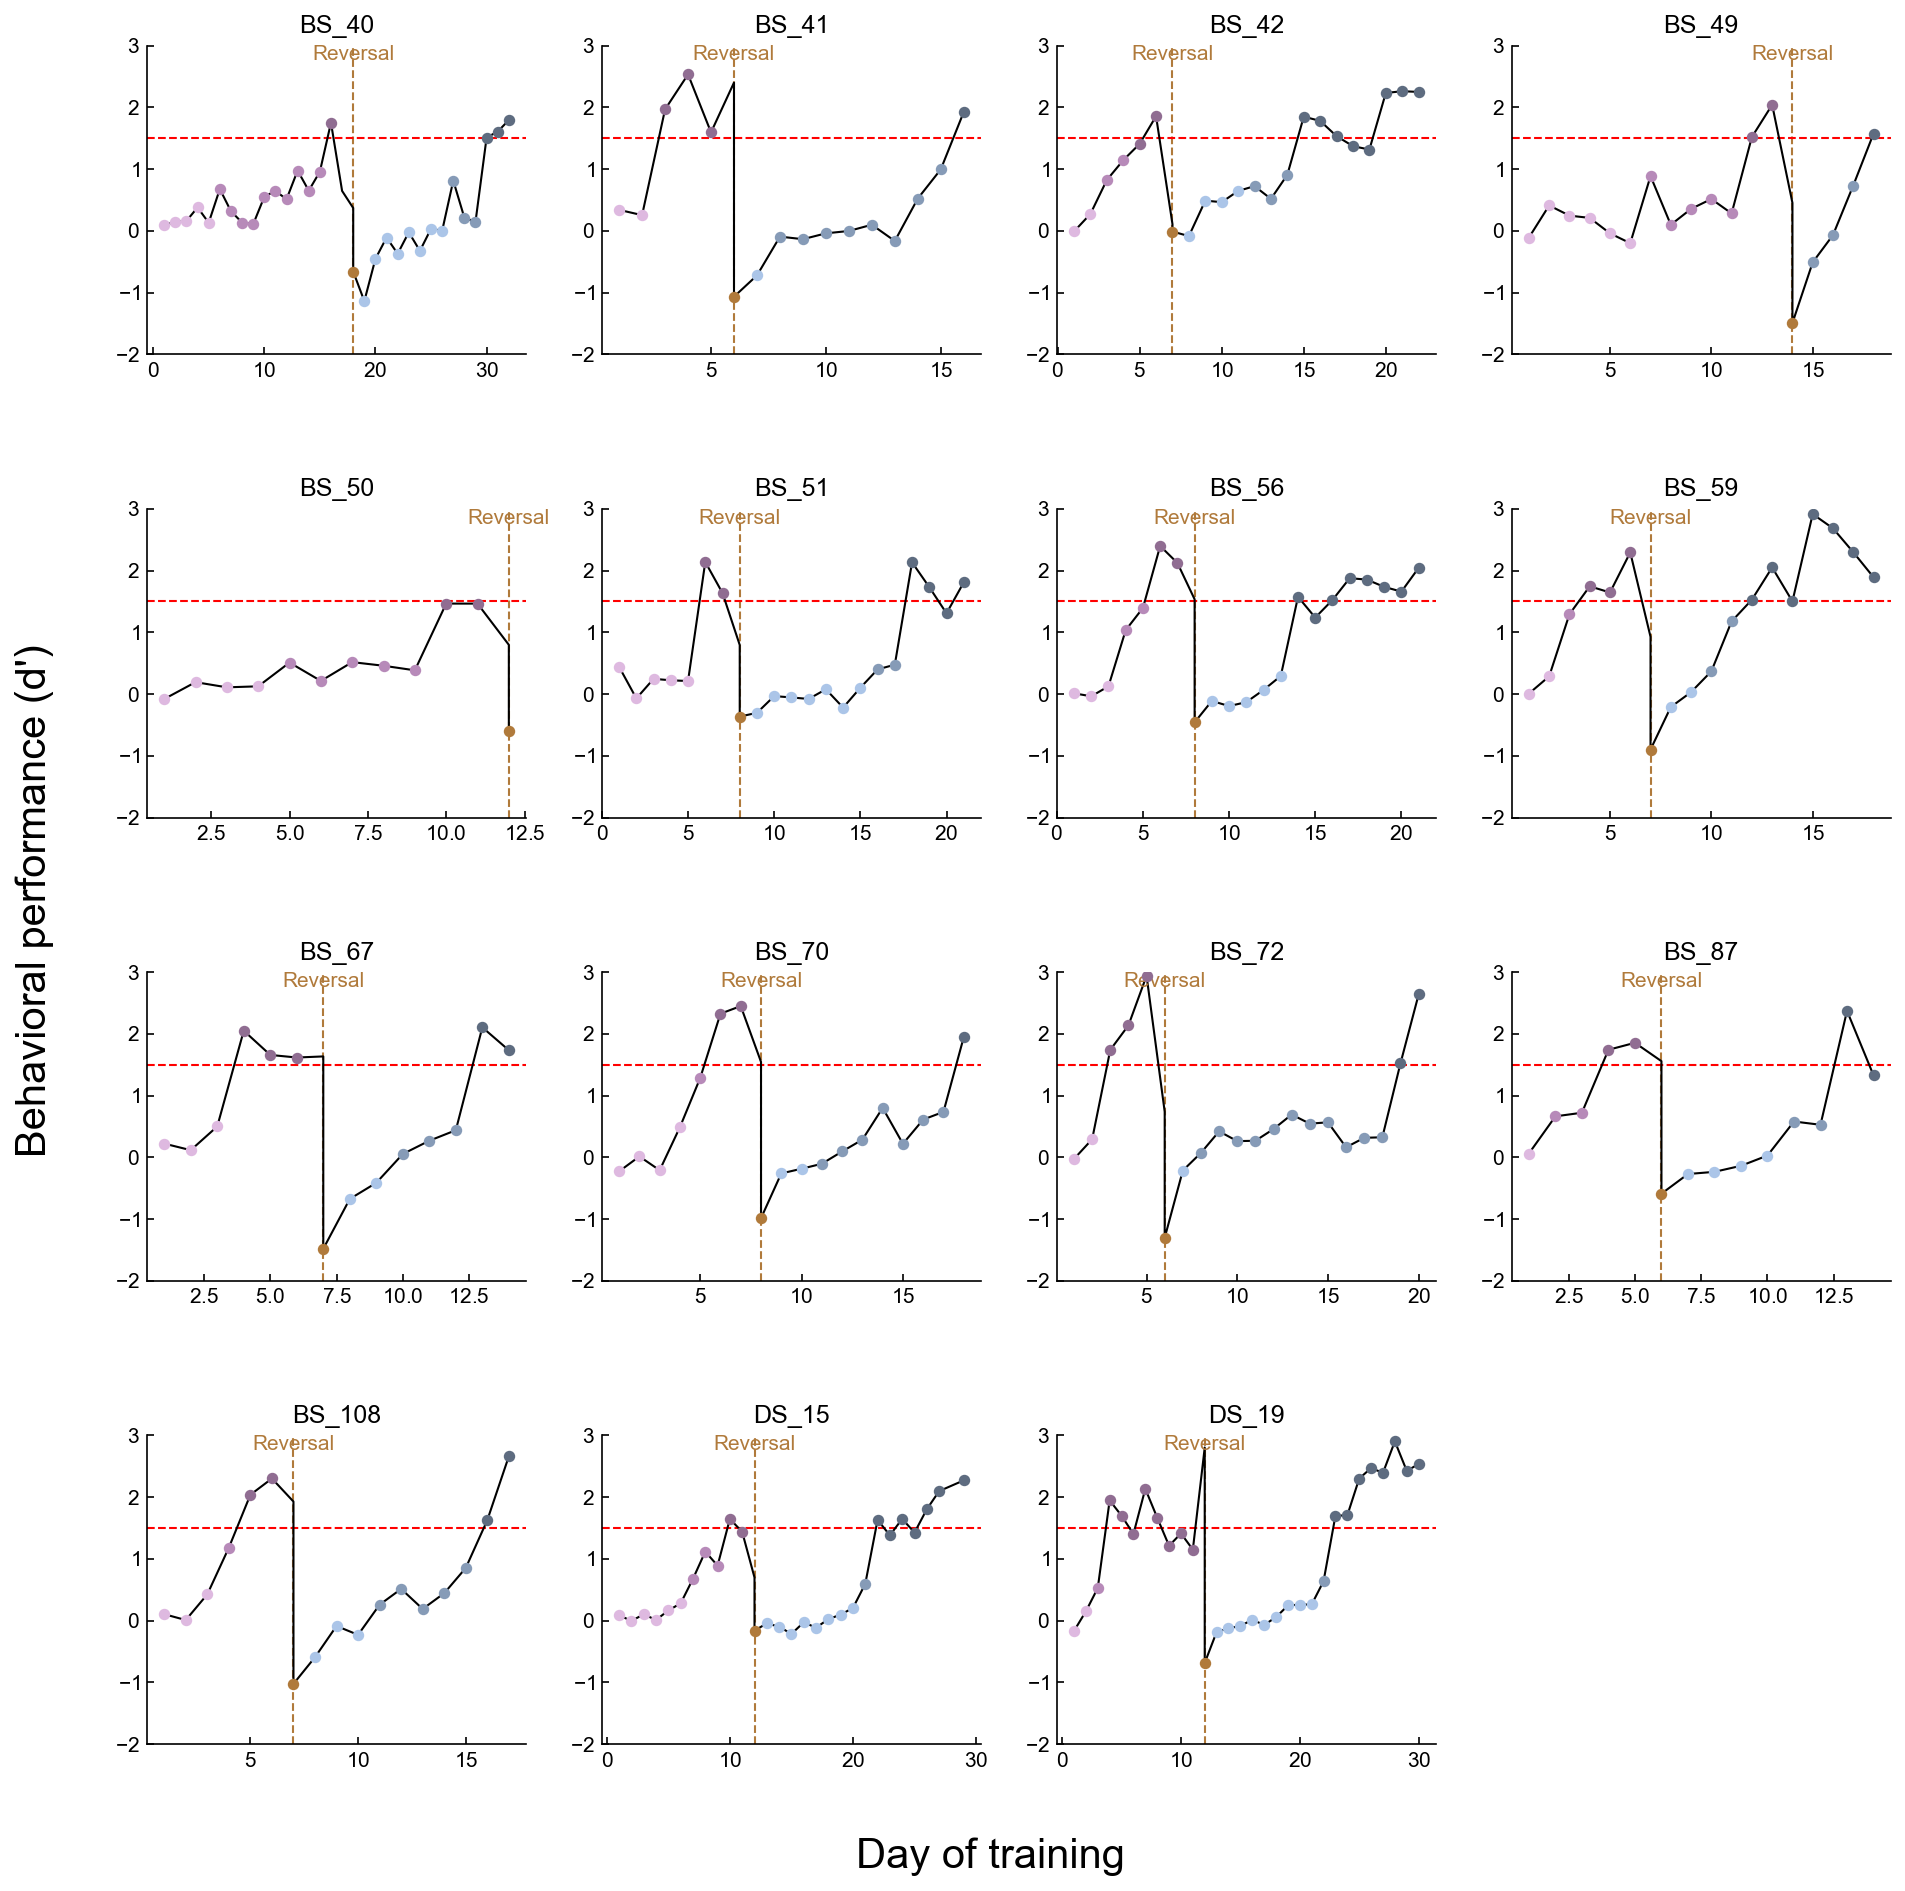

In [35]:
learning_phases,_,_ = ilep.calculateLearningPhasesV2(animals,animalBehaviors,plot=True)
#plt.savefig(os.path.join('D:\\\\TempFigures','All ephys animals learning phases.pdf'),transparent=False,facecolor="white")

In [90]:
EnumSession = []
EnumClust = []
sessions = os.listdir(act_directory)
for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.task in ['passive no behavior']:
        continue
    if sessionfile.meta.task in ['tuning nonreversal','tuning switch','tuning reversal']:
        continue
    if sessionfile.meta.region != 'AC':
        continue
        
    if sessionfile.meta.animal not in animals:
        continue
    
    for clust in sessionfile.clusters.good:
        EnumSession.append(session)
        EnumClust.append(clust)

100%|██████████| 740/740 [00:08<00:00, 86.15it/s] 


In [91]:
EILphases = np.full_like(EnumSession,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumSession)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch','opto switch','tuning switch']:
            EILphases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_early_days:
            EILphases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal']  and day in learning_phases[animal].pre_late_days:
            EILphases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_expert_days:
            EILphases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_early_days:
            EILphases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_late_days:
            EILphases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_expert_days:
            EILphases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 1829/1829 [00:29<00:00, 62.65it/s] 

errors for: []


In [92]:
print(len(EnumSession))

1829


# Load Decoding Data

In [38]:
stim_25s_df = pd.read_csv(stim25sdecodingfilename)
passive_df = pd.read_csv(passivedecodingfilename)
choice_df = pd.read_csv(choicedecodingfilename)
dec_df = pd.concat([stim_25s_df,choice_df,passive_df])

def getDataPoint(df,session,clust,categories,column):
    df = df[df['session']==session]
    df = df[df['clust']==clust]
    df = df[df['categories']==categories]
    val = list(df[column])
    if len(val) == 1:
        return val[0]
    elif len(val) <= 0:
        return np.nan
    else:
        raise Exception('Incorrent length. Duplicate values')

In [39]:
stim_acc = []
choice_acc = []
stim_acc_c = []
choice_acc_c = []
stim_acc_s = []
choice_acc_s = []
pval_stim_s = []
pval_choice_s = []
pval_stim_c = []
pval_choice_c = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    stim_accuracy = getDataPoint(dec_df,session,clust,'stimulus','weighted_accuracy')
    choice_accuracy = getDataPoint(dec_df,session,clust,'response','weighted_accuracy')#weighted_
    
    pvalue_stim_s = getDataPoint(dec_df,session,clust,'stimulus','pval_synthetic_control')
    pvalue_choice_s = getDataPoint(dec_df,session,clust,'response','pval_synthetic_control')
    
    pvalue_stim_c = 0.01#getDataPoint(dec_df,session,clust,'stimulus','pval_shuffled_control')
    pvalue_choice_c = 0.01#getDataPoint(dec_df,session,clust,'response','pval_shuffled_control')
    
    stim_acc.append(stim_accuracy)
    choice_acc.append(choice_accuracy)
    
    pval_stim_s.append(pvalue_stim_s)
    pval_choice_s.append(pvalue_choice_s)
    
    pval_stim_c.append(pvalue_stim_c)
    pval_choice_c.append(pvalue_choice_c)
    
stim_acc = np.array(stim_acc)
choice_acc = np.array(choice_acc)
pval_stim_s = np.array(pval_stim_s)
pval_choice_s = np.array(pval_choice_s)
pval_stim_c = np.array(pval_stim_c)
pval_choice_c = np.array(pval_choice_c)

1829it [00:08, 221.57it/s]


In [40]:
def get_TE_mask(acc,pval_s):#,pval_c):
    low_decoders = np.less(acc,0.5)
    low_accuracies = acc[low_decoders]
    low_magnitudes = np.absolute(low_accuracies-0.5)

    low_magnitudes = np.sort(low_magnitudes)
    task_encoder_threshold = 0.5+low_magnitudes[int(0.95 * len(low_magnitudes))]
    print('Task encoder threshold: '+str(task_encoder_threshold))

    is_finite = np.isfinite(acc)
    #is_valid_pval = np.logical_and(np.less(pval_s,0.05) , np.less(pval_c,0.05))
    is_valid_pval = np.less(pval_s,0.05)
    is_TE = np.greater_equal(acc,task_encoder_threshold)
    is_TE = np.logical_and(is_TE,is_finite)
    is_TE = np.logical_and(is_TE,is_valid_pval)
    return is_TE,task_encoder_threshold

is_TE_s,task_encoder_threshold_s = get_TE_mask(stim_acc,pval_stim_s)#,pval_stim_c)
is_TE_c,task_encoder_threshold_c = get_TE_mask(choice_acc,pval_choice_s)#,pval_choice_c)

Task encoder threshold: 0.55951845
Task encoder threshold: 0.5841134751773049


In [111]:
FRmod_preearly = []
FRmod_prelate = []
FRmod_preexpert = []
FRmod_postearly = []
FRmod_postlate = []
FRmod_postexpert = []

ChoiceMod_preearly = []
ChoiceMod_prelate = []
ChoiceMod_preexpert = []
ChoiceMod_postearly = []
ChoiceMod_postlate = []
ChoiceMod_postexpert = []

# Ramping_preearly = []
# Ramping_prelate = []
# Ramping_preexpert = []
# Ramping_postearly = []
# Ramping_postlate = []
# Ramping_postexpert = []

Stim_Dec_preearly = []
Stim_Dec_prelate = []
Stim_Dec_preexpert = []
Stim_Dec_postearly = []
Stim_Dec_postlate = []
Stim_Dec_postexpert = []

Choice_Dec_preearly = []
Choice_Dec_prelate = []
Choice_Dec_preexpert = []
Choice_Dec_postearly = []
Choice_Dec_postlate = []
Choice_Dec_postexpert = []

Control_Stim_Dec_preearly = []
Control_Stim_Dec_prelate = []
Control_Stim_Dec_preexpert = []
Control_Stim_Dec_postearly = []
Control_Stim_Dec_postlate = []
Control_Stim_Dec_postexpert = []

Control_Choice_Dec_preearly = []
Control_Choice_Dec_prelate = []
Control_Choice_Dec_preexpert = []
Control_Choice_Dec_postearly = []
Control_Choice_Dec_postlate = []
Control_Choice_Dec_postexpert = []

num_nonsig = 0
num_othernan = 0
num_controlnan = 0

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
    except Exception as e:
        print(e)
        FRmod = np.nan
        
    try:
        ChoiceMod = sessionfile.responsiveness[clust]['go'].FRmodulation_choice
    except Exception as e:
        print(f"{session} clust {clust}: {e}")
        ChoiceMod = np.nan
        
    if np.isnan(FRmod) or np.isnan(ChoiceMod):
        continue
        
    if EILphases[idx] not in ['pre expert','post expert'] and sessionfile.meta.animal in ['DS_15','DS_19']:
        continue
        
#     try:
#         Ramp = sessionfile.responsiveness[clust]['go'].rampingMod
#     except Exception as e:
#         print(e)
#         Ramp = np.nan

#     if not is_TE_c[idx]:
#         continue

    if EILphases[idx] not in ['pre early','pre late','pre expert','post early','post late','post expert']:
        continue
    
    stim_acc = getDataPoint(dec_df,session,clust,'stimulus','weighted_accuracy')
    choice_acc = getDataPoint(dec_df,session,clust,'response','weighted_accuracy')
    stim_acc_control = getDataPoint(dec_df,session,clust,'stimulus','synthetic_control_weighted_accuracy')
    choice_acc_control = getDataPoint(dec_df,session,clust,'response','synthetic_control_weighted_accuracy')
    if np.isnan(choice_acc):
        num_othernan += 1
        continue
    if np.isnan(choice_acc_control):
        num_controlnan += 1
        continue
    
#     if getDataPoint(dec_df,session,clust,'stimulus','pval_shuffled_control') > 0.05 or getDataPoint(dec_df,session,clust,'stimulus','pval_synthetic_control') > 0.05:
#         stim_acc = np.nan
#     if getDataPoint(dec_df,session,clust,'response','pval_shuffled_control') > 0.05 or getDataPoint(dec_df,session,clust,'response','pval_synthetic_control') > 0.05:
#         choice_acc = np.nan
    if getDataPoint(dec_df,session,clust,'stimulus','pval_synthetic_control') > 0.05:
        stim_acc = np.nan
    if getDataPoint(dec_df,session,clust,'response','pval_synthetic_control') > 0.05:
        num_nonsig += 1
        choice_acc = np.nan
        continue
        
    if EILphases[idx] == 'pre early':
        FRmod_preearly.append(FRmod)
        ChoiceMod_preearly.append(ChoiceMod)
#         Ramping_preearly.append(Ramp)
        Stim_Dec_preearly.append(stim_acc)
        Choice_Dec_preearly.append(choice_acc)
        Control_Stim_Dec_preearly.append(stim_acc_control)
        Control_Choice_Dec_preearly.append(choice_acc_control)
    elif EILphases[idx] == 'pre late':
        FRmod_prelate.append(FRmod)
        ChoiceMod_prelate.append(ChoiceMod)
#         Ramping_prelate.append(Ramp)
        Stim_Dec_prelate.append(stim_acc)
        Choice_Dec_prelate.append(choice_acc)
        Control_Stim_Dec_prelate.append(stim_acc_control)
        Control_Choice_Dec_prelate.append(choice_acc_control)
    elif EILphases[idx] == 'pre expert':
        FRmod_preexpert.append(FRmod)
        ChoiceMod_preexpert.append(ChoiceMod)
#         Ramping_preexpert.append(Ramp)
        Stim_Dec_preexpert.append(stim_acc)
        Choice_Dec_preexpert.append(choice_acc)
        Control_Stim_Dec_preexpert.append(stim_acc_control)
        Control_Choice_Dec_preexpert.append(choice_acc_control)
    elif EILphases[idx] == 'post early':
        FRmod_postearly.append(FRmod)
        ChoiceMod_postearly.append(ChoiceMod)
#         Ramping_postearly.append(Ramp)
        Stim_Dec_postearly.append(stim_acc)
        Choice_Dec_postearly.append(choice_acc)
        Control_Stim_Dec_postearly.append(stim_acc_control)
        Control_Choice_Dec_postearly.append(choice_acc_control)
    elif EILphases[idx] == 'post late':
        FRmod_postlate.append(FRmod)
        ChoiceMod_postlate.append(ChoiceMod)
#         Ramping_postlate.append(Ramp)
        Stim_Dec_postlate.append(stim_acc)
        Choice_Dec_postlate.append(choice_acc)
        Control_Stim_Dec_postlate.append(stim_acc_control)
        Control_Choice_Dec_postlate.append(choice_acc_control)
    elif EILphases[idx] == 'post expert':
        FRmod_postexpert.append(FRmod)
        ChoiceMod_postexpert.append(ChoiceMod)
#         Ramping_postexpert.append(Ramp)
        Stim_Dec_postexpert.append(stim_acc)
        Choice_Dec_postexpert.append(choice_acc)
        Control_Stim_Dec_postexpert.append(stim_acc_control)
        Control_Choice_Dec_postexpert.append(choice_acc_control)
        
FRmod_preearly = np.array(FRmod_preearly)
FRmod_prelate = np.array(FRmod_prelate)
FRmod_preexpert = np.array(FRmod_preexpert)
FRmod_postearly = np.array(FRmod_postearly)
FRmod_postlate = np.array(FRmod_postlate)
FRmod_postexpert = np.array(FRmod_postexpert)

ChoiceMod_preearly = np.array(ChoiceMod_preearly)
ChoiceMod_prelate = np.array(ChoiceMod_prelate)
ChoiceMod_preexpert = np.array(ChoiceMod_preexpert)
ChoiceMod_postearly = np.array(ChoiceMod_postearly)
ChoiceMod_postlate = np.array(ChoiceMod_postlate)
ChoiceMod_postexpert = np.array(ChoiceMod_postexpert)

# Ramping_preearly = np.array(Ramping_preearly)
# Ramping_prelate = np.array(Ramping_prelate)
# Ramping_preexpert = np.array(Ramping_preexpert)
# Ramping_postearly = np.array(Ramping_postearly)
# Ramping_postlate = np.array(Ramping_postlate)
# Ramping_postexpert = np.array(Ramping_postexpert)
        
Stim_Dec_preearly = np.array(Stim_Dec_preearly)
Stim_Dec_prelate = np.array(Stim_Dec_prelate)
Stim_Dec_preexpert = np.array(Stim_Dec_preexpert)
Stim_Dec_postearly = np.array(Stim_Dec_postearly)
Stim_Dec_postlate = np.array(Stim_Dec_postlate)
Stim_Dec_postexpert = np.array(Stim_Dec_postexpert)

Choice_Dec_preearly = np.array(Choice_Dec_preearly)
Choice_Dec_prelate = np.array(Choice_Dec_prelate)
Choice_Dec_preexpert = np.array(Choice_Dec_preexpert)
Choice_Dec_postearly = np.array(Choice_Dec_postearly)
Choice_Dec_postlate = np.array(Choice_Dec_postlate)
Choice_Dec_postexpert = np.array(Choice_Dec_postexpert)

Control_Stim_Dec_preearly = np.array(Control_Stim_Dec_preearly)
Control_Stim_Dec_prelate = np.array(Control_Stim_Dec_prelate)
Control_Stim_Dec_preexpert = np.array(Control_Stim_Dec_preexpert)
Control_Stim_Dec_postearly = np.array(Control_Stim_Dec_postearly)
Control_Stim_Dec_postlate = np.array(Control_Stim_Dec_postlate)
Control_Stim_Dec_postexpert = np.array(Control_Stim_Dec_postexpert)

Control_Choice_Dec_preearly = np.array(Control_Choice_Dec_preearly)
Control_Choice_Dec_prelate = np.array(Control_Choice_Dec_prelate)
Control_Choice_Dec_preexpert = np.array(Control_Choice_Dec_preexpert)
Control_Choice_Dec_postearly = np.array(Control_Choice_Dec_postearly)
Control_Choice_Dec_postlate = np.array(Control_Choice_Dec_postlate)
Control_Choice_Dec_postexpert = np.array(Control_Choice_Dec_postexpert)

1392it [00:29, 47.90it/s] 

DS_15_15_AC.pickle clust 0: 'types.SimpleNamespace' object has no attribute 'FRmodulation_choice'
DS_15_15_AC.pickle clust 6: 'types.SimpleNamespace' object has no attribute 'FRmodulation_choice'
DS_15_15_AC.pickle clust 7: 'types.SimpleNamespace' object has no attribute 'FRmodulation_choice'
DS_15_15_AC.pickle clust 10: 'types.SimpleNamespace' object has no attribute 'FRmodulation_choice'
DS_15_15_AC.pickle clust 12: 'types.SimpleNamespace' object has no attribute 'FRmodulation_choice'
DS_15_15_AC.pickle clust 19: 'types.SimpleNamespace' object has no attribute 'FRmodulation_choice'
DS_15_15_AC.pickle clust 28: 'types.SimpleNamespace' object has no attribute 'FRmodulation_choice'
DS_15_15_AC.pickle clust 29: 'types.SimpleNamespace' object has no attribute 'FRmodulation_choice'
DS_15_15_AC.pickle clust 36: 'types.SimpleNamespace' object has no attribute 'FRmodulation_choice'
DS_15_15_AC.pickle clust 41: 'types.SimpleNamespace' object has no attribute 'FRmodulation_choice'
DS_15_15_AC.p

1408it [00:29, 61.57it/s]

DS_15_15_AC.pickle clust 78: 'types.SimpleNamespace' object has no attribute 'FRmodulation_choice'
DS_15_15_AC.pickle clust 81: 'types.SimpleNamespace' object has no attribute 'FRmodulation_choice'
DS_15_15_AC.pickle clust 86: 'types.SimpleNamespace' object has no attribute 'FRmodulation_choice'
DS_15_15_AC.pickle clust 88: 'types.SimpleNamespace' object has no attribute 'FRmodulation_choice'
DS_15_15_AC.pickle clust 91: 'types.SimpleNamespace' object has no attribute 'FRmodulation_choice'
DS_15_15_AC.pickle clust 101: 'types.SimpleNamespace' object has no attribute 'FRmodulation_choice'
DS_15_15_AC.pickle clust 111: 'types.SimpleNamespace' object has no attribute 'FRmodulation_choice'
DS_15_15_AC.pickle clust 113: 'types.SimpleNamespace' object has no attribute 'FRmodulation_choice'
DS_15_15_AC.pickle clust 114: 'types.SimpleNamespace' object has no attribute 'FRmodulation_choice'
DS_15_15_AC.pickle clust 122: 'types.SimpleNamespace' object has no attribute 'FRmodulation_choice'
DS_15

1829it [00:36, 49.55it/s] 


In [112]:
Control_Stim_Dec_overall = np.concatenate([Control_Stim_Dec_preearly,Control_Stim_Dec_prelate,Control_Stim_Dec_preexpert,Control_Stim_Dec_postearly,Control_Stim_Dec_postlate,Control_Stim_Dec_postexpert])
FRmod_Stim_overall = np.concatenate([FRmod_preearly,FRmod_prelate,FRmod_preexpert,FRmod_postearly,FRmod_postlate,FRmod_postexpert])

Control_Choice_Dec_overall = np.concatenate([Control_Choice_Dec_preearly,Control_Choice_Dec_prelate,Control_Choice_Dec_preexpert,Control_Choice_Dec_postearly,Control_Choice_Dec_postlate,Control_Choice_Dec_postexpert])
ChoiceMod_Stim_overall = np.concatenate([ChoiceMod_preearly,ChoiceMod_prelate,ChoiceMod_preexpert,ChoiceMod_postearly,ChoiceMod_postlate,ChoiceMod_postexpert])

In [113]:
num_nonsig

27

In [114]:
num_othernan

620

In [115]:
num_controlnan

0

In [116]:
print(np.sum(np.isfinite(Choice_Dec_preearly)))
print(np.sum(np.isfinite(Choice_Dec_prelate)))
print(np.sum(np.isfinite(Choice_Dec_preexpert)))
print(np.sum(np.isfinite(Choice_Dec_postearly)))
print(np.sum(np.isfinite(Choice_Dec_postlate)))
print(np.sum(np.isfinite(Choice_Dec_postexpert)))

101
118
34
166
167
67


In [117]:
22+32+9+47+24+26

160

In [125]:
101+118+34+166+167+67# + 27 + 620

653

# Figures -- Median

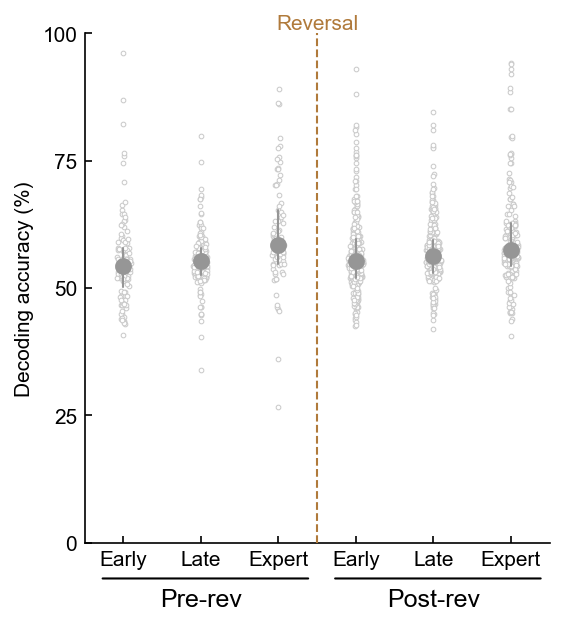

In [9]:
#Firing rate modulation graphs

size=5

#FRmod_baseline_median = np.nanmedian(np.abs(FRmod_preearly))
#print('baseline = '+str(FRmod_baseline_median))

fig, ax = plt.subplots(figsize=(4,4.5))
# fig, ax = plt.subplots(figsize=(5,3))
data = [Stim_Dec_preearly,Stim_Dec_prelate,Stim_Dec_preexpert,Stim_Dec_postearly,Stim_Dec_postlate,Stim_Dec_postexpert]
data = [np.abs(column[np.isfinite(column)]) for column in data]
#num_animal = [preearly_animal_num,prelate_animal_num,preexpert_animal_num,postearly_animal_num,postlate_animal_num,postexpert_animal_num]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.25)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.25)
colors = NCR_CR_cmap((Y-1)/5)

ax.scatter(X, Y, s=size, ec=GOOD_GREY, fc='white', lw=0.5,zorder=-10)
#ax.set_yscale('log',subs=[])

#Plot summary
for idx,column in enumerate(data):    
    eye_color=GOOD_GREY#NCR_CR_cmap((percentCR-40)/20)
    
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    #border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    border_color=colorsys.hls_to_rgb(h,l,s)

    summary_size=50
    summary_width=1
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    
    ax.scatter([idx], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx, idx], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)

ax.set_ylim([0,1])
ax.set_yticks([0,0.25,0.5,0.75,1])
ax.set_yticklabels(['0','25','50','75','100'])
ax.set_ylabel('Decoding accuracy (%)')

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())

    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.5,zorder=-5)
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')


#NORMAL
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, -0.13304656298982956/1.5, 'Pre-rev', ha='center', va='top', fontsize=12)
ax.text(xtick_pos_post, -0.13304656298982956/1.5, 'Post-rev', ha='center', va='top',  fontsize=12)
ax.annotate('', xy=(0.03, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(0.99, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

#fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Stimulus decoding performance over phases V'+str(current_version)+'.pdf'),transparent=False,facecolor="white")

### V3

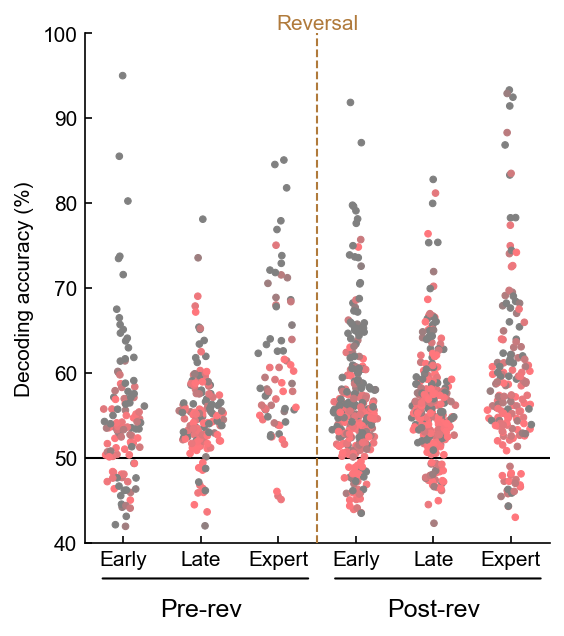

In [23]:
#Firing rate modulation graphs

size=10

#FRmod_baseline_median = np.nanmedian(np.abs(FRmod_preearly))
#print('baseline = '+str(FRmod_baseline_median))

fig, ax = plt.subplots(figsize=(4,4.5))
# fig, ax = plt.subplots(figsize=(5,3))
data = [Stim_Dec_preearly,Stim_Dec_prelate,Stim_Dec_preexpert,Stim_Dec_postearly,Stim_Dec_postlate,Stim_Dec_postexpert]
FRmoddata = [FRmod_preearly,FRmod_prelate,FRmod_preexpert,FRmod_postearly,FRmod_postlate,FRmod_postexpert]
#data = [np.abs(column[np.isfinite(column)]) for column in data]
#num_animal = [preearly_animal_num,prelate_animal_num,preexpert_animal_num,postearly_animal_num,postlate_animal_num,postexpert_animal_num]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.75,minjitter=0.075)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.75,minjitter=0.075)
colors = NCR_CR_cmap((np.concatenate(FRmoddata)-1)/5)

ax.scatter(X, Y, s=size, ec=colors, fc=colors, lw=0.5,zorder=-10)
#ax.set_yscale('log',subs=[])

#Plot summary
for idx,column in enumerate(data):    
    eye_color=GOOD_GREY#NCR_CR_cmap((percentCR-40)/20)
    
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    #border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    border_color=colorsys.hls_to_rgb(h,l,s)

    summary_size=50
    summary_width=1
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    
#     ax.scatter([idx], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
#     ax.plot([idx, idx], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

ax.axhline(0.5,color='k',linestyle='-',zorder=-20,lw=1)
ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)

ax.set_ylim([0.4,1])
ax.set_yticks([0.4,0.5,0.6,0.7,0.8,0.9,1])
ax.set_yticklabels(['40','50','60','70','80','90','100'])
ax.set_ylabel('Decoding accuracy (%)')

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())

    
# ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.5,zorder=-5)
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')


#NORMAL
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim())+0.01
t1 = ax.text(xtick_pos_pre, Yval, 'Pre-rev', ha='center', va='top', fontsize=12,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post-rev', ha='center', va='top',  fontsize=12,color='k')
ax.annotate('', xy=(0.03, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(0.99, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Stimulus decoding performance over phases V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=(t1,t2), bbox_inches='tight')

### V4

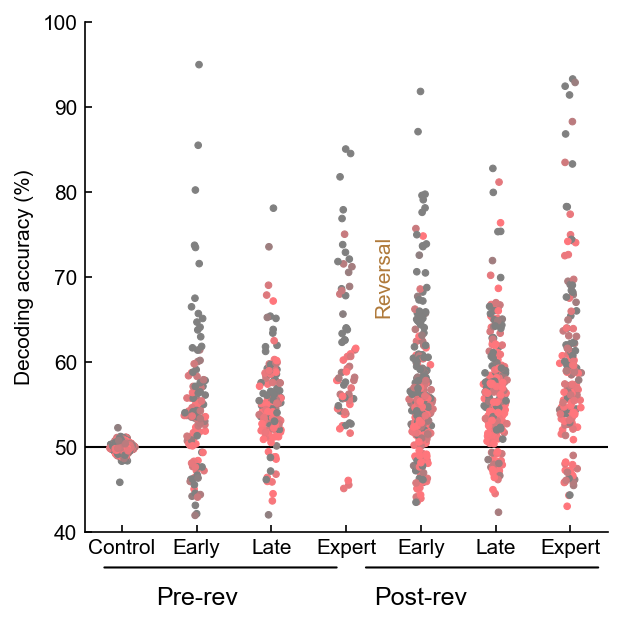

In [18]:
#Firing rate modulation graphs

size=10

#FRmod_baseline_median = np.nanmedian(np.abs(FRmod_preearly))
#print('baseline = '+str(FRmod_baseline_median))

fig, ax = plt.subplots(figsize=(4.5,4.5))
# fig, ax = plt.subplots(figsize=(5,3))
data = [Control_Stim_Dec_overall,Stim_Dec_preearly,Stim_Dec_prelate,Stim_Dec_preexpert,Stim_Dec_postearly,Stim_Dec_postlate,Stim_Dec_postexpert]
FRmoddata = [FRmod_Stim_overall,FRmod_preearly,FRmod_prelate,FRmod_preexpert,FRmod_postearly,FRmod_postlate,FRmod_postexpert]
#data = [np.abs(column[np.isfinite(column)]) for column in data]
#num_animal = [preearly_animal_num,prelate_animal_num,preexpert_animal_num,postearly_animal_num,postlate_animal_num,postexpert_animal_num]
labels = ['Control','Early','Late','Expert','Early','Late','Expert']
numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.35,minjitter=0.075)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.35,minjitter=0.075)
colors = NCR_CR_cmap((np.concatenate(FRmoddata)-1)/5)

ax.scatter(X, Y, s=size, ec=colors, fc=colors, lw=0.5,zorder=-10)
#ax.set_yscale('log',subs=[])

#Plot summary
for idx,column in enumerate(data):    
    eye_color=GOOD_GREY#NCR_CR_cmap((percentCR-40)/20)
    
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    #border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    border_color=colorsys.hls_to_rgb(h,l,s)

    summary_size=50
    summary_width=1
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    
#     ax.scatter([idx], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
#     ax.plot([idx, idx], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

ax.axhline(0.5,color='k',linestyle='-',zorder=-20,lw=1)

ax.set_ylim([0.4,1])
ax.set_yticks([0.4,0.5,0.6,0.7,0.8,0.9,1])
ax.set_yticklabels(['40','50','60','70','80','90','100'])
ax.set_ylabel('Decoding accuracy (%)')

ax.set_xlim([-0.5,6.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())

    
rev = 3.5
size = 0.3
center = np.mean(ax.get_ylim())
ax.text(rev,center,'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center',rotation=90)
#ax.plot([rev,rev],[ax.get_ylim()[0],center-size],color=SWITCH_COLOR,lw=1,linestyle='-')
#ax.plot([rev,rev],[center+size,ax.get_ylim()[1]],color=SWITCH_COLOR,lw=1,linestyle='-')


#NORMAL
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim())+0.01
t1 = ax.text(xtick_pos_pre, Yval, 'Pre-rev', ha='center', va='top', fontsize=12,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post-rev', ha='center', va='top',  fontsize=12,color='k')
ax.annotate('', xy=(0.03, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(0.99, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Stimulus decoding performance over phases V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=(t1,t2), bbox_inches='tight')

### V5

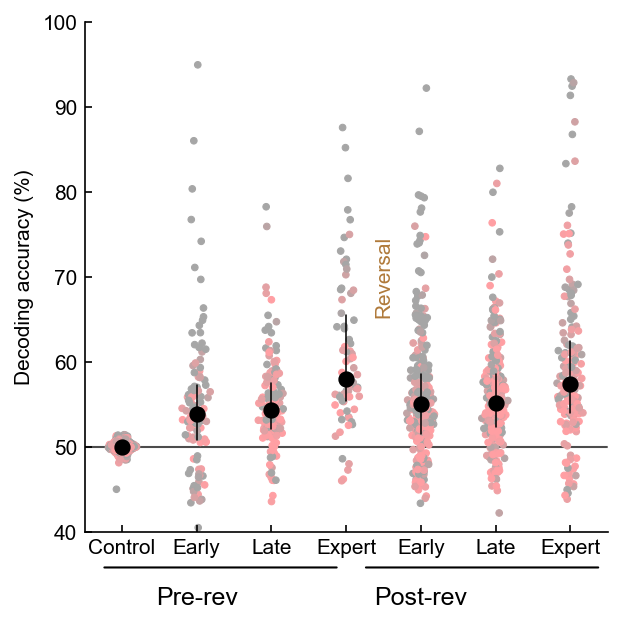

In [27]:
#Firing rate modulation graphs

size=10

#FRmod_baseline_median = np.nanmedian(np.abs(FRmod_preearly))
#print('baseline = '+str(FRmod_baseline_median))

fig, ax = plt.subplots(figsize=(4.5,4.5))
# fig, ax = plt.subplots(figsize=(5,3))
data = [Control_Stim_Dec_overall,Stim_Dec_preearly,Stim_Dec_prelate,Stim_Dec_preexpert,Stim_Dec_postearly,Stim_Dec_postlate,Stim_Dec_postexpert]
FRmoddata = [FRmod_Stim_overall,FRmod_preearly,FRmod_prelate,FRmod_preexpert,FRmod_postearly,FRmod_postlate,FRmod_postexpert]
#data = [np.abs(column[np.isfinite(column)]) for column in data]
#num_animal = [preearly_animal_num,prelate_animal_num,preexpert_animal_num,postearly_animal_num,postlate_animal_num,postexpert_animal_num]
labels = ['Control','Early','Late','Expert','Early','Late','Expert']
numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.4,minjitter=0.075)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.4,minjitter=0.075)
colors = NCR_CR_cmap((np.concatenate(FRmoddata)-1)/5)

ax.scatter(X, Y, s=size, ec=colors, fc=colors, lw=0.5,zorder=-10)
#ax.set_yscale('log',subs=[])

#Plot summary
for idx,column in enumerate(data):
    column = ilep.rmnan(column)
    eye_color=GOOD_GREY#NCR_CR_cmap((percentCR-40)/20)
    
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    #border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    border_color=colorsys.hls_to_rgb(h,l,s)
    
    border_color = 'k'
    eye_color = 'k'

    summary_size=50
    summary_width=0.75
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    
    ax.scatter([idx], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx, idx], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

ax.axhline(0.5,color='k',linestyle='-',zorder=-20,lw=1)

ax.set_ylim([0.4,1])
ax.set_yticks([0.4,0.5,0.6,0.7,0.8,0.9,1])
ax.set_yticklabels(['40','50','60','70','80','90','100'])
ax.set_ylabel('Decoding accuracy (%)')

ax.set_xlim([-0.5,6.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())

    
rev = 3.5
size = 0.3
center = np.mean(ax.get_ylim())
ax.text(rev,center,'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center',rotation=90)
#ax.plot([rev,rev],[ax.get_ylim()[0],center-size],color=SWITCH_COLOR,lw=1,linestyle='-')
#ax.plot([rev,rev],[center+size,ax.get_ylim()[1]],color=SWITCH_COLOR,lw=1,linestyle='-')

ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.3,zorder=-5)

#NORMAL
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim())+0.01
t1 = ax.text(xtick_pos_pre, Yval, 'Pre-rev', ha='center', va='top', fontsize=12,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post-rev', ha='center', va='top',  fontsize=12,color='k')
ax.annotate('', xy=(0.03, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(0.99, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Stimulus decoding performance over phases V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=(t1,t2), bbox_inches='tight')

### V6

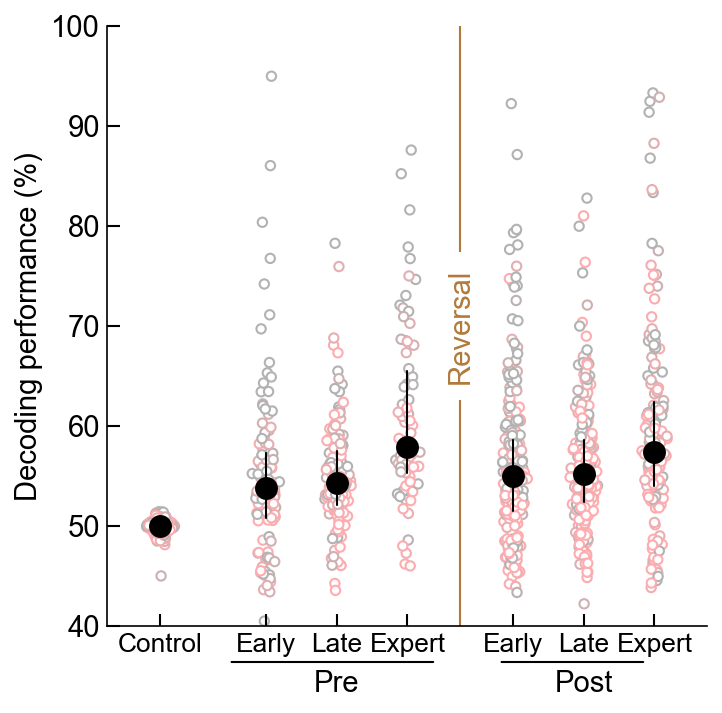

In [22]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(4, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25

################################################################################################################

size = 20
summary_size=100
summary_width=1#0.75

mn = 3.5
spread = 2.5
    
###
    
FRmod_baseline_median = 3.5
data = [Control_Stim_Dec_overall,Stim_Dec_preearly,Stim_Dec_prelate,Stim_Dec_preexpert,Stim_Dec_postearly,Stim_Dec_postlate,Stim_Dec_postexpert]
FRmoddata = [FRmod_Stim_overall,FRmod_preearly,FRmod_prelate,FRmod_preexpert,FRmod_postearly,FRmod_postlate,FRmod_postexpert]
labels = ['Control','Early','Late','Expert','Early','Late','Expert']
numCon = len(data)
X = [np.ones(len(l))*idx + polarity*switch_offset for idx,(l,polarity) in enumerate(zip(data,[-3,-1,-1,-1,1,1,1]))]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.4,minjitter=0.075)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.4,minjitter=0.075)
colors = NCR_CR_cmap((np.concatenate(FRmoddata)-1)/5)

ax.scatter(X, Y, s=size, ec=colors, fc='white', lw=1,zorder=-10)

#Plot summary
for idx,(column,polarity) in enumerate(zip(data,[-3,-1,-1,-1,1,1,1])):
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= 'k'#NCR_CR_cmap((percentCR-40)/20)
    border_color = 'k'#NCR_CR_cmap((percentCR-40)/20)  
#     r,g,b = mpl.colors.to_rgb(eye_color)
#     h,l,s = colorsys.rgb_to_hls(r,g,b)
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)
    
    ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.4,zorder=-5)

################################################################################################################
ax.set_ylim([0.4,1])
ax.set_yticks([0.4,0.5,0.6,0.7,0.8,0.9,1])
ax.set_yticklabels(['40','50','60','70','80','90','100'])
ylab = ax.set_ylabel('Decoding performance (%)')

ax.set_xlim([-0.75-3*switch_offset,6.75+switch_offset])
ax.set_xticks([0-3*switch_offset,1-switch_offset,2-switch_offset,3-switch_offset,4+switch_offset,5+switch_offset,6+switch_offset])
ax.set_xticklabels(labels)

xtick_pos_con = ax.get_xticks()[0]
xtick_pos_pre = ax.get_xticks()[2]
xtick_pos_post = ax.get_xticks()[5]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
# t1 = ax.text(xtick_pos_con, Yval, 'Control', ha='center', va='bottom', fontsize=stdfont,color='k')
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.2, -stdyfrac), xycoords='axes fraction', xytext=(0.55, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.65, -stdyfrac), xycoords='axes fraction', xytext=(0.9, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(3.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([3.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([3.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Stimulus decoding performance over phases V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

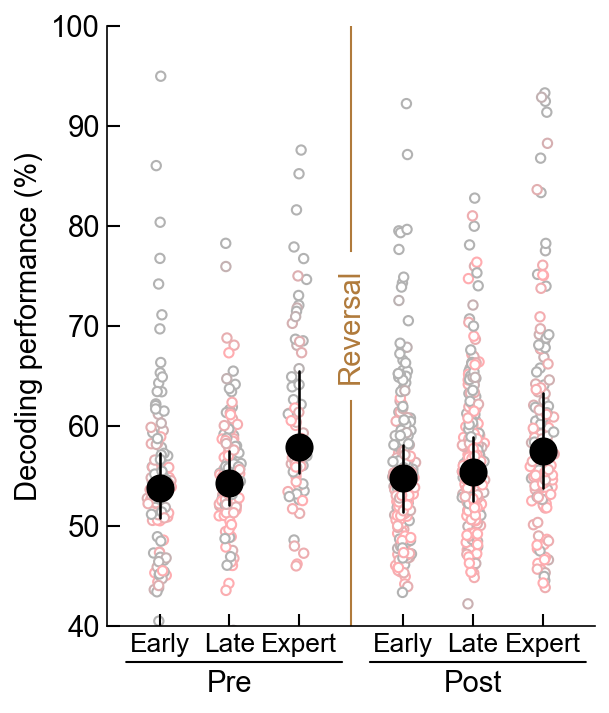

In [12]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25

################################################################################################################

size = 20
summary_size=150
summary_width=1.25#0.75

mn = 3.5
spread = 2.5
    
###
    
FRmod_baseline_median = 3.5
# data = [Control_Stim_Dec_overall,Stim_Dec_preearly,Stim_Dec_prelate,Stim_Dec_preexpert,Stim_Dec_postearly,Stim_Dec_postlate,Stim_Dec_postexpert]
# FRmoddata = [FRmod_Stim_overall,FRmod_preearly,FRmod_prelate,FRmod_preexpert,FRmod_postearly,FRmod_postlate,FRmod_postexpert]
# labels = ['Control','Early','Late','Expert','Early','Late','Expert']
data = [Stim_Dec_preearly,Stim_Dec_prelate,Stim_Dec_preexpert,Stim_Dec_postearly,Stim_Dec_postlate,Stim_Dec_postexpert]
FRmoddata = [FRmod_preearly,FRmod_prelate,FRmod_preexpert,FRmod_postearly,FRmod_postlate,FRmod_postexpert]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)
X = [np.ones(len(l))*idx + polarity*switch_offset for idx,(l,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1]))]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.4,minjitter=0.075)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.4,minjitter=0.075)
colors = NCR_CR_cmap((np.concatenate(FRmoddata)-1)/5)

ax.scatter(X, Y, s=size, ec=colors, fc='white', lw=1,zorder=-10)

#Plot summary
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1])):
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= 'k'#NCR_CR_cmap((percentCR-40)/20)
    border_color = 'k'#NCR_CR_cmap((percentCR-40)/20)  
#     r,g,b = mpl.colors.to_rgb(eye_color)
#     h,l,s = colorsys.rgb_to_hls(r,g,b)
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)
    
    ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.4,zorder=-5)

################################################################################################################
ax.set_ylim([0.4,1])
ax.set_yticks([0.4,0.5,0.6,0.7,0.8,0.9,1])
ax.set_yticklabels(['40','50','60','70','80','90','100'])
ylab = ax.set_ylabel('Decoding performance (%)')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
# t1 = ax.text(xtick_pos_con, Yval, 'Control', ha='center', va='bottom', fontsize=stdfont,color='k')
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Stimulus decoding performance over phases V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [13]:
data_dec = SimpleNamespace()
data_dec.preearly = np.abs(Stim_Dec_preearly)
data_dec.prelate = np.abs(Stim_Dec_prelate)
data_dec.preexpert = np.abs(Stim_Dec_preexpert)
data_dec.postearly = np.abs(Stim_Dec_postearly)
data_dec.postlate = np.abs(Stim_Dec_postlate)
data_dec.postexpert = np.abs(Stim_Dec_postexpert)
ilep.mannwhitneycompareall(data_dec)
pass

pre-early   n = 113
pre-late    n = 158
pre-expert  n = 74
post-early  n = 256
post-late   n = 299
post-expert n = 143
pre-early  to pre-late   : 0.419553727726941
pre-late   to pre-expert : 6.104951758510033e-07
pre-early  to pre-expert : 2.6433750843725596e-06
post-early to post-late  : 0.035964771523883866
post-late  to post-expert: 0.0033865529555811577
post-early to post-expert: 3.1542623885430734e-05


In [15]:
print(len(Stim_Dec_preearly))
print(len(Stim_Dec_prelate))
print(len(Stim_Dec_preexpert))
print(len(Stim_Dec_postearly))
print(len(Stim_Dec_postlate))
print(len(Stim_Dec_postexpert))

148
188
117
306
342
262


In [16]:
113+158+74+256+299+143

1043

In [54]:
148+187+97+306+342+220-36

1264

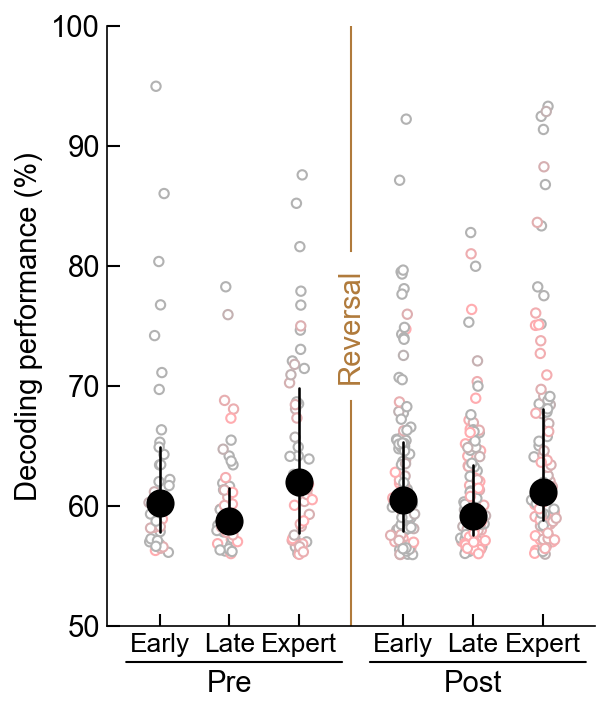

In [17]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25

################################################################################################################

size = 20
summary_size=150
summary_width=1.25#0.75

mn = 3.5
spread = 2.5
    
###
    
FRmod_baseline_median = 3.5
# data = [Control_Stim_Dec_overall,Stim_Dec_preearly,Stim_Dec_prelate,Stim_Dec_preexpert,Stim_Dec_postearly,Stim_Dec_postlate,Stim_Dec_postexpert]
# FRmoddata = [FRmod_Stim_overall,FRmod_preearly,FRmod_prelate,FRmod_preexpert,FRmod_postearly,FRmod_postlate,FRmod_postexpert]
# labels = ['Control','Early','Late','Expert','Early','Late','Expert']
data = [Stim_Dec_preearly,Stim_Dec_prelate,Stim_Dec_preexpert,Stim_Dec_postearly,Stim_Dec_postlate,Stim_Dec_postexpert]
FRmoddata = [FRmod_preearly,FRmod_prelate,FRmod_preexpert,FRmod_postearly,FRmod_postlate,FRmod_postexpert]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)
X = [np.ones(len(l))*idx + polarity*switch_offset for idx,(l,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1]))]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.4,minjitter=0.075)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.4,minjitter=0.075)
colors = NCR_CR_cmap((np.concatenate(FRmoddata)-1)/5)

ax.scatter(X, Y, s=size, ec=colors, fc='white', lw=1,zorder=-10)

#Plot summary
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1])):
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= 'k'#NCR_CR_cmap((percentCR-40)/20)
    border_color = 'k'#NCR_CR_cmap((percentCR-40)/20)  
#     r,g,b = mpl.colors.to_rgb(eye_color)
#     h,l,s = colorsys.rgb_to_hls(r,g,b)
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)
    
    ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.4,zorder=-5)

################################################################################################################
ax.set_ylim([0.5,1])
ax.set_yticks([0.5,0.6,0.7,0.8,0.9,1])
ax.set_yticklabels(['50','60','70','80','90','100'])
ylab = ax.set_ylabel('Decoding performance (%)')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
# t1 = ax.text(xtick_pos_con, Yval, 'Control', ha='center', va='bottom', fontsize=stdfont,color='k')
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Stimulus decoding performance task encoders over phases V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [29]:
data_dec = SimpleNamespace()
data_dec.preearly = np.abs(Stim_Dec_preearly)
data_dec.prelate = np.abs(Stim_Dec_prelate)
data_dec.preexpert = np.abs(Stim_Dec_preexpert)
data_dec.postearly = np.abs(Stim_Dec_postearly)
data_dec.postlate = np.abs(Stim_Dec_postlate)
data_dec.postexpert = np.abs(Stim_Dec_postexpert)
ilep.nonparametricIndependentStatsCompareToPrevious(data_dec)
pass

            Source        SS      DF        MS          F         p-unc  \
0            phase  0.174299     3.0  0.058100  11.131638  3.162222e-07   
1          context  0.140767     1.0  0.140767  26.970306  2.351144e-07   
2  phase * context  0.129030     3.0  0.043010   8.240525  1.938573e-05   
3         Residual  7.787248  1492.0  0.005219        NaN           NaN   

        np2  
0  0.021893  
1  0.017756  
2  0.016299  
3       NaN  

          phase         A             B         p-unc        p-corr    hedges
7   post-expert  baseline  experimental  2.257702e-03  4.515404e-03 -0.402887
8     post-late  baseline  experimental  2.997064e-02  3.996086e-02 -0.125715
9    pre-expert  baseline  experimental  1.017492e-07  4.069968e-07 -0.791652
10     pre-late  baseline  experimental  4.195537e-01  4.195537e-01  0.022022
key preearly has 113 non-nan elements
key prelate has 158 non-nan elements
key preexpert has 74 non-nan elements
key postearly has 256 non-nan elements
key postlat

In [30]:
data_dec = SimpleNamespace()
data_dec.preearly = np.abs(Stim_Dec_preearly)
data_dec.prelate = np.abs(Stim_Dec_prelate)
data_dec.preexpert = np.abs(Stim_Dec_preexpert)
data_dec.postearly = np.abs(Stim_Dec_postearly)
data_dec.postlate = np.abs(Stim_Dec_postlate)
data_dec.postexpert = np.abs(Stim_Dec_postexpert)
ilep.nonparametricIndependentStatsCompareToOwnEarly(data_dec)
pass

            Source        SS      DF        MS          F         p-unc  \
0            phase  0.133841     3.0  0.044614   7.685170  4.285103e-05   
1          context  0.155318     1.0  0.155318  26.755198  2.643525e-07   
2  phase * context  0.141218     3.0  0.047073   8.108811  2.350421e-05   
3         Residual  8.150425  1404.0  0.005805        NaN           NaN   

        np2  
0  0.016156  
1  0.018700  
2  0.017031  
3       NaN  

          phase         A             B         p-unc    p-corr    hedges
7   post-expert  baseline  experimental  1.577131e-05  0.000032 -0.482386
8     post-late  baseline  experimental  2.997064e-02  0.039961 -0.125715
9    pre-expert  baseline  experimental  8.811250e-07  0.000004 -0.608634
10     pre-late  baseline  experimental  4.195537e-01  0.419554  0.022022
key preearly has 113 non-nan elements
key prelate has 158 non-nan elements
key preexpert has 74 non-nan elements
key postearly has 256 non-nan elements
key postlate has 299 non-nan el

{'whiskers': [<matplotlib.lines.Line2D at 0x1f8cb982850>,
 'caps': [<matplotlib.lines.Line2D at 0x1f8cb982f10>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f8cb982580>,
 'medians': [<matplotlib.lines.Line2D at 0x1f8cb9885e0>,
 'fliers': [<matplotlib.lines.Line2D at 0x1f8cb988910>,
 'means': []}

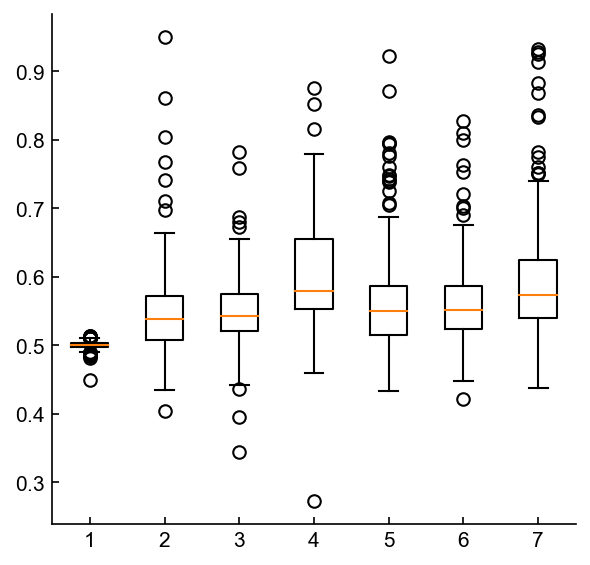

In [31]:
fig, ax = plt.subplots(figsize=(4.5,4.5))
# fig, ax = plt.subplots(figsize=(5,3))
data = [Control_Stim_Dec_overall,Stim_Dec_preearly,Stim_Dec_prelate,Stim_Dec_preexpert,Stim_Dec_postearly,Stim_Dec_postlate,Stim_Dec_postexpert]
data = [ilep.rmnan(d) for d in data]
FRmoddata = [FRmod_Stim_overall,FRmod_preearly,FRmod_prelate,FRmod_preexpert,FRmod_postearly,FRmod_postlate,FRmod_postexpert]
#data = [np.abs(column[np.isfinite(column)]) for column in data]
#num_animal = [preearly_animal_num,prelate_animal_num,preexpert_animal_num,postearly_animal_num,postlate_animal_num,postexpert_animal_num]
labels = ['Control','Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

ax.boxplot(data)

In [11]:
data_dec = SimpleNamespace()
data_dec.preearly = Stim_Dec_preearly
data_dec.prelate = Stim_Dec_prelate
data_dec.preexpert = Stim_Dec_preexpert
data_dec.postearly = Stim_Dec_postearly
data_dec.postlate = Stim_Dec_postlate
data_dec.postexpert = Stim_Dec_postexpert
ilep.nonparametricIndependentStatsCompareToPrevious(data_dec)
pass

            Source        SS      DF        MS          F         p-unc  \
0            phase  0.144594     3.0  0.048198   9.379624  3.843466e-06   
1          context  0.112706     1.0  0.112706  21.933285  3.082975e-06   
2  phase * context  0.166567     3.0  0.055522  10.805030  5.047800e-07   
3         Residual  7.569111  1473.0  0.005139        NaN           NaN   

        np2  
0  0.018745  
1  0.014672  
2  0.021532  
3       NaN  

          phase         A             B         p-unc        p-corr    hedges
7   post-expert  baseline  experimental  1.711770e-04  3.423539e-04 -0.442528
8     post-late  baseline  experimental  2.772960e-01  3.697279e-01 -0.013860
9    pre-expert  baseline  experimental  1.017492e-07  4.069968e-07 -0.791652
10     pre-late  baseline  experimental  4.195537e-01  4.195537e-01  0.022022
key preearly has 113 non-nan elements
key prelate has 158 non-nan elements
key preexpert has 74 non-nan elements
key postearly has 294 non-nan elements
key postlat

In [12]:
data_dec = SimpleNamespace()
data_dec.preearly = Stim_Dec_preearly
data_dec.prelate = Stim_Dec_prelate
data_dec.preexpert = Stim_Dec_preexpert
data_dec.postearly = Stim_Dec_postearly
data_dec.postlate = Stim_Dec_postlate
data_dec.postexpert = Stim_Dec_postexpert
ilep.nonparametricIndependentStatsCompareToOwnEarly(data_dec)
pass

            Source        SS      DF        MS          F     p-unc       np2
0            phase  0.146228     3.0  0.048743   8.365905  0.000016  0.016888
1          context  0.108361     1.0  0.108361  18.598516  0.000017  0.012570
2  phase * context  0.157663     3.0  0.052554   9.020100  0.000006  0.018185
3         Residual  8.512286  1461.0  0.005826        NaN       NaN       NaN

          phase         A             B         p-unc    p-corr    hedges
7   post-expert  baseline  experimental  1.316104e-05  0.000026 -0.424158
8     post-late  baseline  experimental  2.772960e-01  0.369728 -0.013860
9    pre-expert  baseline  experimental  8.811250e-07  0.000004 -0.608634
10     pre-late  baseline  experimental  4.195537e-01  0.419554  0.022022
key preearly has 113 non-nan elements
key prelate has 158 non-nan elements
key preexpert has 74 non-nan elements
key postearly has 294 non-nan elements
key postlate has 261 non-nan elements
key postexpert has 162 non-nan elements


# Choice

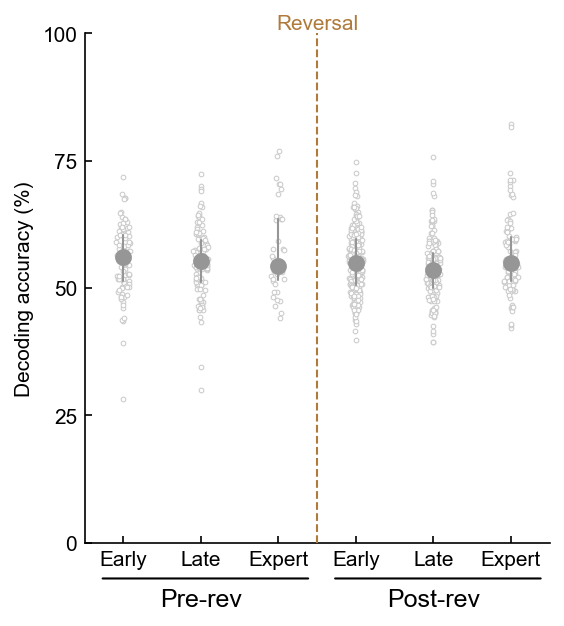

In [11]:
#Firing rate modulation graphs

size=5

#FRmod_baseline_median = np.nanmedian(np.abs(FRmod_preearly))
#print('baseline = '+str(FRmod_baseline_median))

fig, ax = plt.subplots(figsize=(4,4.5))
# fig, ax = plt.subplots(figsize=(5,3))
data = [Choice_Dec_preearly,Choice_Dec_prelate,Choice_Dec_preexpert,Choice_Dec_postearly,Choice_Dec_postlate,Choice_Dec_postexpert]
data = [np.abs(column[np.isfinite(column)]) for column in data]
#num_animal = [preearly_animal_num,prelate_animal_num,preexpert_animal_num,postearly_animal_num,postlate_animal_num,postexpert_animal_num]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.25)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.25)
colors = NCR_CR_cmap((Y-1)/5)

ax.scatter(X, Y, s=size, ec=GOOD_GREY, fc='white', lw=0.5,zorder=-10)
#ax.set_yscale('log',subs=[])

#Plot summary
for idx,column in enumerate(data):    
    eye_color=GOOD_GREY#NCR_CR_cmap((percentCR-40)/20)
    
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    #border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    border_color=colorsys.hls_to_rgb(h,l,s)

    summary_size=50
    summary_width=1
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    
    ax.scatter([idx], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx, idx], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)

ax.set_ylim([0,1])
ax.set_yticks([0,0.25,0.5,0.75,1])
ax.set_yticklabels(['0','25','50','75','100'])
ax.set_ylabel('Decoding accuracy (%)')

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())

    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.5,zorder=-5)
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')


#NORMAL
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, -0.13304656298982956/1.5, 'Pre-rev', ha='center', va='top', fontsize=12)
ax.text(xtick_pos_post, -0.13304656298982956/1.5, 'Post-rev', ha='center', va='top',  fontsize=12)
ax.annotate('', xy=(0.03, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(0.99, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Choice decoding performance over phases V'+str(current_version)+'.pdf'),transparent=False,facecolor="white")

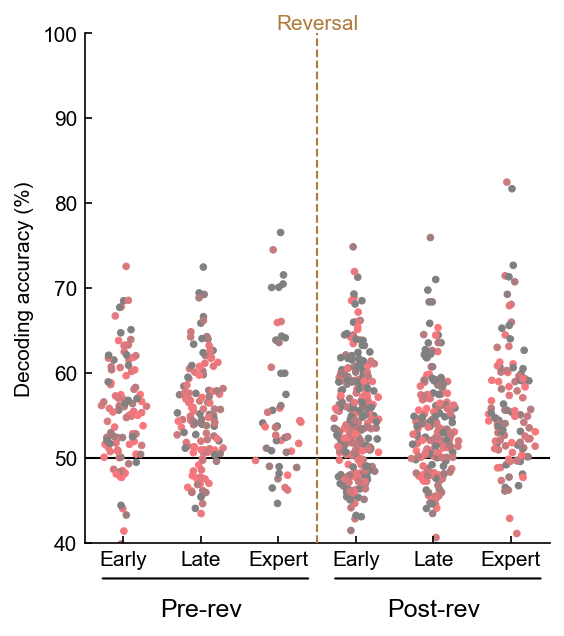

In [24]:
#Firing rate modulation graphs

size=10

#FRmod_baseline_median = np.nanmedian(np.abs(FRmod_preearly))
#print('baseline = '+str(FRmod_baseline_median))

fig, ax = plt.subplots(figsize=(4,4.5))
# fig, ax = plt.subplots(figsize=(5,3))
data = [Choice_Dec_preearly,Choice_Dec_prelate,Choice_Dec_preexpert,Choice_Dec_postearly,Choice_Dec_postlate,Choice_Dec_postexpert]
Rampingdata = [Ramping_preearly,Ramping_prelate,Ramping_preexpert,Ramping_postearly,Ramping_postlate,Ramping_postexpert]
Rampingdata = [np.abs(d) for d in Rampingdata]
#data = [np.abs(column[np.isfinite(column)]) for column in data]
#num_animal = [preearly_animal_num,prelate_animal_num,preexpert_animal_num,postearly_animal_num,postlate_animal_num,postexpert_animal_num]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.75,minjitter=0.075)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.75,minjitter=0.075)
colors = NCR_CR_cmap((np.concatenate(Rampingdata))/3)

ax.scatter(X, Y, s=size, ec=colors, fc=colors, lw=0.5,zorder=-10)
#ax.set_yscale('log',subs=[])

#Plot summary
for idx,column in enumerate(data):    
    eye_color=GOOD_GREY#NCR_CR_cmap((percentCR-40)/20)
    
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    #border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    border_color=colorsys.hls_to_rgb(h,l,s)

    summary_size=50
    summary_width=1
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    
#     ax.scatter([idx], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
#     ax.plot([idx, idx], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

ax.axhline(0.5,color='k',linestyle='-',zorder=-20,lw=1)
ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)

ax.set_ylim([0.4,1])
ax.set_yticks([0.4,0.5,0.6,0.7,0.8,0.9,1])
ax.set_yticklabels(['40','50','60','70','80','90','100'])
ax.set_ylabel('Decoding accuracy (%)')

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())

    
# ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.5,zorder=-5)
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')


#NORMAL
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim())+0.01
t1 = ax.text(xtick_pos_pre, Yval, 'Pre-rev', ha='center', va='top', fontsize=12,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post-rev', ha='center', va='top',  fontsize=12,color='k')
ax.annotate('', xy=(0.03, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(0.99, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Choice decoding performance over phases V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=(t1,t2), bbox_inches='tight')

### V4

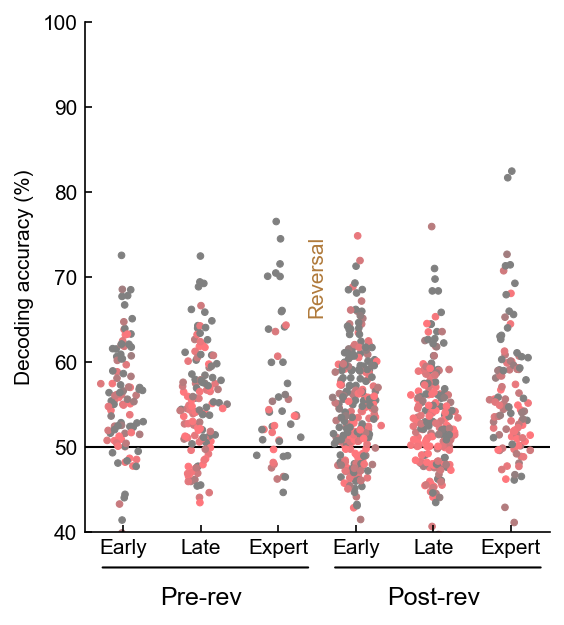

In [18]:
#Firing rate modulation graphs

size=10

#FRmod_baseline_median = np.nanmedian(np.abs(FRmod_preearly))
#print('baseline = '+str(FRmod_baseline_median))

fig, ax = plt.subplots(figsize=(4,4.5))
# fig, ax = plt.subplots(figsize=(5,3))
data = [Choice_Dec_preearly,Choice_Dec_prelate,Choice_Dec_preexpert,Choice_Dec_postearly,Choice_Dec_postlate,Choice_Dec_postexpert]
FRmoddata = [FRmod_preearly,FRmod_prelate,FRmod_preexpert,FRmod_postearly,FRmod_postlate,FRmod_postexpert]
Rampingdata = [Ramping_preearly,Ramping_prelate,Ramping_preexpert,Ramping_postearly,Ramping_postlate,Ramping_postexpert]
Rampingdata = [np.abs(d) for d in Rampingdata]
#data = [np.abs(column[np.isfinite(column)]) for column in data]
#num_animal = [preearly_animal_num,prelate_animal_num,preexpert_animal_num,postearly_animal_num,postlate_animal_num,postexpert_animal_num]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.75,minjitter=0.075)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.75,minjitter=0.075)
#colors = NCR_CR_cmap((np.concatenate(Rampingdata))/3)
colors = NCR_CR_cmap((np.concatenate(FRmoddata)-1)/5)

ax.scatter(X, Y, s=size, ec=colors, fc=colors, lw=0.5,zorder=-10)
#ax.set_yscale('log',subs=[])

#Plot summary
for idx,column in enumerate(data):    
    eye_color=GOOD_GREY#NCR_CR_cmap((percentCR-40)/20)
    
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    #border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    border_color=colorsys.hls_to_rgb(h,l,s)

    summary_size=50
    summary_width=1
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    
#     ax.scatter([idx], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
#     ax.plot([idx, idx], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

ax.axhline(0.5,color='k',linestyle='-',zorder=-20,lw=1)

ax.set_ylim([0.4,1])
ax.set_yticks([0.4,0.5,0.6,0.7,0.8,0.9,1])
ax.set_yticklabels(['40','50','60','70','80','90','100'])
ax.set_ylabel('Decoding accuracy (%)')

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())

    
rev = 2.5
size = 0.3
center = np.mean(ax.get_ylim())
ax.text(rev,center,'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center',rotation=90)
#ax.plot([rev,rev],[ax.get_ylim()[0],center-size],color=SWITCH_COLOR,lw=1,linestyle='-')
#ax.plot([rev,rev],[center+size,ax.get_ylim()[1]],color=SWITCH_COLOR,lw=1,linestyle='-')


#NORMAL
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim())+0.01
t1 = ax.text(xtick_pos_pre, Yval, 'Pre-rev', ha='center', va='top', fontsize=12,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post-rev', ha='center', va='top',  fontsize=12,color='k')
ax.annotate('', xy=(0.03, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(0.99, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Choice decoding performance over phases V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=(t1,t2), bbox_inches='tight')

## V6

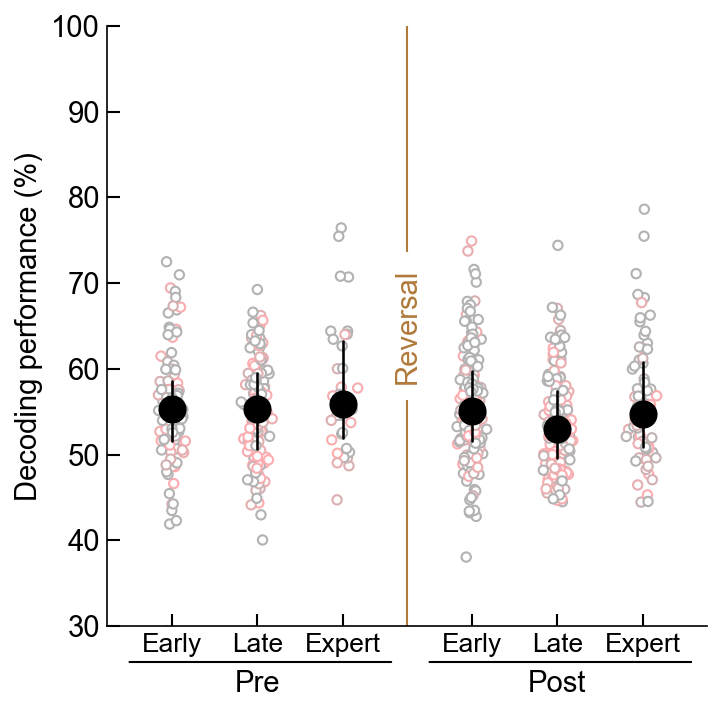

In [123]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(4, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25

################################################################################################################
size = 20
summary_size=150
summary_width=1.25#0.75

mn = 3.5
spread = 2.5

FRmod_baseline_median = 3.5
data = [Choice_Dec_preearly,Choice_Dec_prelate,Choice_Dec_preexpert,Choice_Dec_postearly,Choice_Dec_postlate,Choice_Dec_postexpert]
FRmoddata = [FRmod_preearly,FRmod_prelate,FRmod_preexpert,FRmod_postearly,FRmod_postlate,FRmod_postexpert]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)
X = [np.ones(len(l))*idx + polarity*switch_offset for idx,(l,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1]))]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.4,minjitter=0.075)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.4,minjitter=0.075)
colors = NCR_CR_cmap((np.concatenate(FRmoddata)-1)/5)

ax.scatter(X, Y, s=size, ec=colors, fc='white', lw=1,zorder=-10)

#Plot summary
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1])):
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= 'k'#NCR_CR_cmap((percentCR-40)/20)
    border_color = 'k'#NCR_CR_cmap((percentCR-40)/20)  
#     r,g,b = mpl.colors.to_rgb(eye_color)
#     h,l,s = colorsys.rgb_to_hls(r,g,b)
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)
    
    ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.4,zorder=-5)

################################################################################################################
ax.set_ylim([0.3,1])
ax.set_yticks([0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
ax.set_yticklabels(['30','40','50','60','70','80','90','100'])
ylab = ax.set_ylabel('Decoding performance (%)')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
# t1 = ax.text(xtick_pos_con, Yval, 'Control', ha='center', va='bottom', fontsize=stdfont,color='k')
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.98, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Choice decoding performance over phases V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [124]:
data_dec = SimpleNamespace()
data_dec.preearly = Choice_Dec_preearly
data_dec.prelate = Choice_Dec_prelate
data_dec.preexpert = Choice_Dec_preexpert
data_dec.postearly = Choice_Dec_postearly
data_dec.postlate = Choice_Dec_postlate
data_dec.postexpert = Choice_Dec_postexpert
ilep.mannwhitneycompareall(data_dec)
pass

pre-early   n = 101
pre-late    n = 118
pre-expert  n = 34
post-early  n = 166
post-late   n = 167
post-expert n = 67
pre-early  to pre-late   : 0.9854378291004627
pre-late   to pre-expert : 0.5322814802308571
pre-early  to pre-expert : 0.5363428235552271
post-early to post-late  : 0.00876141465966459
post-late  to post-expert: 0.057968719887026676
post-early to post-expert: 0.9854378291004627


In [47]:
70
87
29
156
153
49

49

In [24]:
# TEs

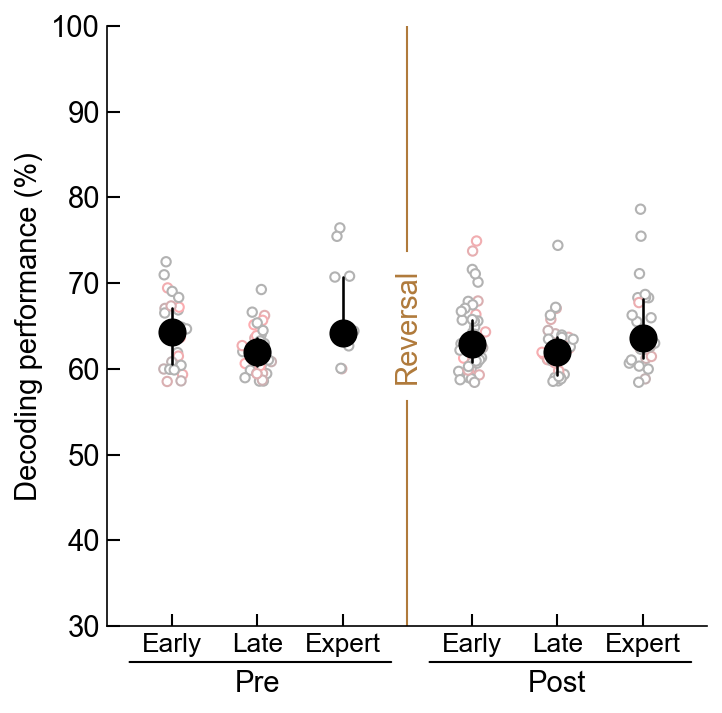

In [29]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(4, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25

################################################################################################################
size = 20
summary_size=150
summary_width=1.25#0.75

mn = 3.5
spread = 2.5

FRmod_baseline_median = 3.5
data = [Choice_Dec_preearly,Choice_Dec_prelate,Choice_Dec_preexpert,Choice_Dec_postearly,Choice_Dec_postlate,Choice_Dec_postexpert]
FRmoddata = [FRmod_preearly,FRmod_prelate,FRmod_preexpert,FRmod_postearly,FRmod_postlate,FRmod_postexpert]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)
X = [np.ones(len(l))*idx + polarity*switch_offset for idx,(l,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1]))]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.4,minjitter=0.075)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.4,minjitter=0.075)
colors = NCR_CR_cmap((np.concatenate(FRmoddata)-1)/5)

ax.scatter(X, Y, s=size, ec=colors, fc='white', lw=1,zorder=-10)

#Plot summary
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1])):
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= 'k'#NCR_CR_cmap((percentCR-40)/20)
    border_color = 'k'#NCR_CR_cmap((percentCR-40)/20)  
#     r,g,b = mpl.colors.to_rgb(eye_color)
#     h,l,s = colorsys.rgb_to_hls(r,g,b)
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)
    
    ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.4,zorder=-5)

################################################################################################################
ax.set_ylim([0.3,1])
ax.set_yticks([0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
ax.set_yticklabels(['30','40','50','60','70','80','90','100'])
ylab = ax.set_ylabel('Decoding performance (%)')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
# t1 = ax.text(xtick_pos_con, Yval, 'Control', ha='center', va='bottom', fontsize=stdfont,color='k')
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.98, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Choice decoding performance TEs over phases V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [30]:
data_dec = SimpleNamespace()
data_dec.preearly = Choice_Dec_preearly
data_dec.prelate = Choice_Dec_prelate
data_dec.preexpert = Choice_Dec_preexpert
data_dec.postearly = Choice_Dec_postearly
data_dec.postlate = Choice_Dec_postlate
data_dec.postexpert = Choice_Dec_postexpert
ilep.mannwhitneycompareall(data_dec)
pass

pre-early   n = 27
pre-late    n = 37
pre-expert  n = 12
post-early  n = 49
post-late   n = 32
post-expert n = 26
pre-early  to pre-late   : 0.0773546876155694
pre-late   to pre-expert : 0.0571982421245499
pre-early  to pre-expert : 0.4377842422527143
post-early to post-late  : 0.24408176640759682
post-late  to post-expert: 0.08578482367674752
post-early to post-expert: 0.35133921300610493


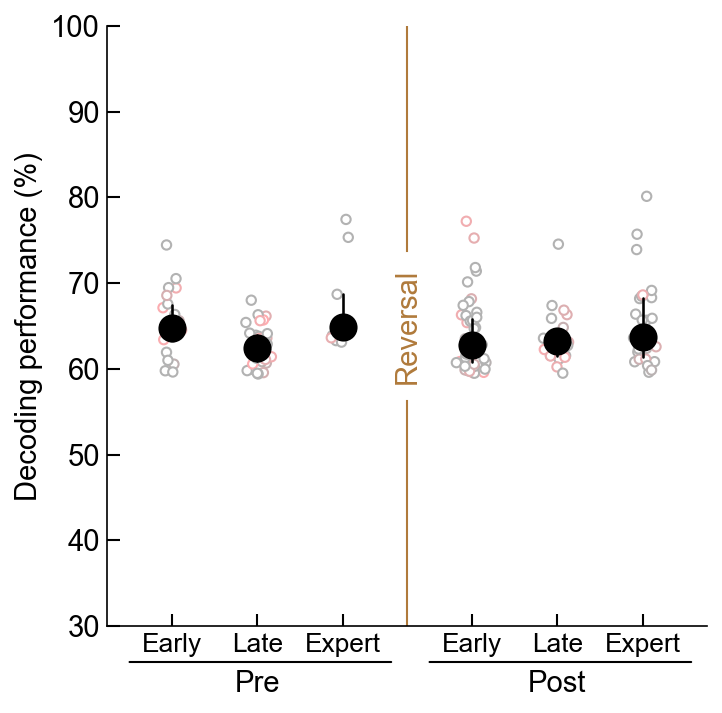

In [12]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(4, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25

################################################################################################################
size = 20
summary_size=150
summary_width=1.25#0.75

mn = 3.5
spread = 2.5

FRmod_baseline_median = 3.5
data = [Choice_Dec_preearly,Choice_Dec_prelate,Choice_Dec_preexpert,Choice_Dec_postearly,Choice_Dec_postlate,Choice_Dec_postexpert]
FRmoddata = [FRmod_preearly,FRmod_prelate,FRmod_preexpert,FRmod_postearly,FRmod_postlate,FRmod_postexpert]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)
X = [np.ones(len(l))*idx + polarity*switch_offset for idx,(l,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1]))]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.4,minjitter=0.075)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.4,minjitter=0.075)
colors = NCR_CR_cmap((np.concatenate(FRmoddata)-1)/5)

ax.scatter(X, Y, s=size, ec=colors, fc='white', lw=1,zorder=-10)

#Plot summary
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1])):
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= 'k'#NCR_CR_cmap((percentCR-40)/20)
    border_color = 'k'#NCR_CR_cmap((percentCR-40)/20)  
#     r,g,b = mpl.colors.to_rgb(eye_color)
#     h,l,s = colorsys.rgb_to_hls(r,g,b)
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)
    
    ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.4,zorder=-5)

################################################################################################################
ax.set_ylim([0.3,1])
ax.set_yticks([0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
ax.set_yticklabels(['30','40','50','60','70','80','90','100'])
ylab = ax.set_ylabel('Decoding performance (%)')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
# t1 = ax.text(xtick_pos_con, Yval, 'Control', ha='center', va='bottom', fontsize=stdfont,color='k')
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.98, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Choice TE decoding performance over phases V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [35]:
data_dec = SimpleNamespace()
data_dec.preearly = Choice_Dec_preearly
data_dec.prelate = Choice_Dec_prelate
data_dec.preexpert = Choice_Dec_preexpert
data_dec.postearly = Choice_Dec_postearly
data_dec.postlate = Choice_Dec_postlate
data_dec.postexpert = Choice_Dec_postexpert
ilep.mannwhitneycompareall(data_dec)
pass

pre-early   n = 98
pre-late    n = 120
pre-expert  n = 32
post-early  n = 166
post-late   n = 168
post-expert n = 85
pre-early  to pre-late   : 0.9029316007538885
pre-late   to pre-expert : 0.49642434647847256
pre-early  to pre-expert : 0.5225937247819431
post-early to post-late  : 0.009165861088385664
post-late  to post-expert: 0.09065344170037885
post-early to post-expert: 0.9029316007538885


In [31]:
98+120+32+166+168+85

669

# Figures -- Mean

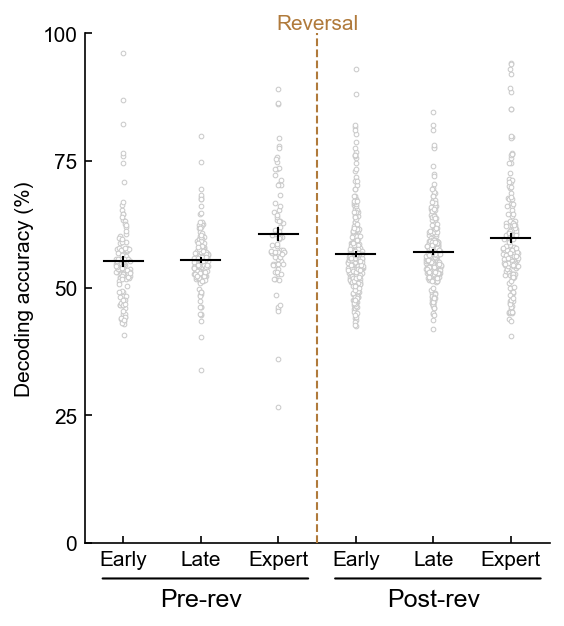

In [10]:
#Firing rate modulation graphs

size=5

#FRmod_baseline_median = np.nanmedian(np.abs(FRmod_preearly))
#print('baseline = '+str(FRmod_baseline_median))

fig, ax = plt.subplots(figsize=(4,4.5))
# fig, ax = plt.subplots(figsize=(5,3))
data = [Stim_Dec_preearly,Stim_Dec_prelate,Stim_Dec_preexpert,Stim_Dec_postearly,Stim_Dec_postlate,Stim_Dec_postexpert]
data = [np.abs(column[np.isfinite(column)]) for column in data]
#num_animal = [preearly_animal_num,prelate_animal_num,preexpert_animal_num,postearly_animal_num,postlate_animal_num,postexpert_animal_num]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.25)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.25)
colors = NCR_CR_cmap((Y-1)/5)

ax.scatter(X, Y, s=size, ec=GOOD_GREY, fc='white', lw=0.5,zorder=-10)
#ax.set_yscale('log',subs=[])

#Plot summary
for idx,column in enumerate(data):    
    eye_color=GOOD_GREY#NCR_CR_cmap((percentCR-40)/20)
    
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    #border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    border_color=colorsys.hls_to_rgb(h,l,s)

    summary_size=50
    summary_width=1
    
    #Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    mean = np.mean(column)
    SEM = sem(column)
    Q1 = mean-SEM
    Q3 = mean+SEM
    
#     ax.scatter([idx], [mean], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
#     ax.plot([idx, idx], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
    width=0.25
    ax.plot([idx-width,idx+width],[mean]*2,color='k',lw=1)
    ax.plot([idx]*2,[mean-SEM,mean+SEM],color='k',lw=1)

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)

ax.set_ylim([0,1])
ax.set_yticks([0,0.25,0.5,0.75,1])
ax.set_yticklabels(['0','25','50','75','100'])
ax.set_ylabel('Decoding accuracy (%)')

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())

    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.5,zorder=-5)
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')


#NORMAL
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, -0.13304656298982956/1.5, 'Pre-rev', ha='center', va='top', fontsize=12)
ax.text(xtick_pos_post, -0.13304656298982956/1.5, 'Post-rev', ha='center', va='top',  fontsize=12)
ax.annotate('', xy=(0.03, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(0.99, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Stimulus decoding mean performance over phases V'+str(current_version)+'.pdf'),transparent=False,facecolor="white")

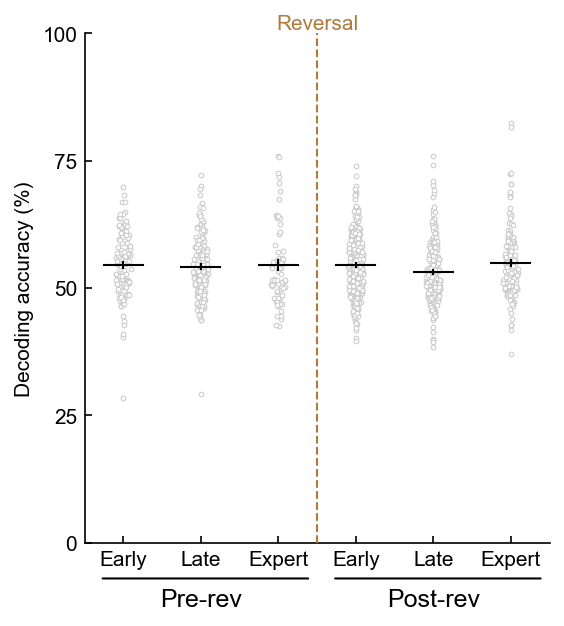

In [22]:
#Firing rate modulation graphs

size=5

#FRmod_baseline_median = np.nanmedian(np.abs(FRmod_preearly))
#print('baseline = '+str(FRmod_baseline_median))

fig, ax = plt.subplots(figsize=(4,4.5))
# fig, ax = plt.subplots(figsize=(5,3))
data = [Choice_Dec_preearly,Choice_Dec_prelate,Choice_Dec_preexpert,Choice_Dec_postearly,Choice_Dec_postlate,Choice_Dec_postexpert]
data = [np.abs(column[np.isfinite(column)]) for column in data]
#num_animal = [preearly_animal_num,prelate_animal_num,preexpert_animal_num,postearly_animal_num,postlate_animal_num,postexpert_animal_num]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.25)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.25)
colors = NCR_CR_cmap((Y-1)/5)

ax.scatter(X, Y, s=size, ec=GOOD_GREY, fc='white', lw=0.5,zorder=-10)
#ax.set_yscale('log',subs=[])

#Plot summary
for idx,column in enumerate(data):    
    eye_color=GOOD_GREY#NCR_CR_cmap((percentCR-40)/20)
    
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    #border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    border_color=colorsys.hls_to_rgb(h,l,s)

    summary_size=50
    summary_width=1
    
    #Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    mean = np.mean(column)
    SEM = sem(column)
    Q1 = mean-SEM
    Q3 = mean+SEM
    
#     ax.scatter([idx], [mean], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
#     ax.plot([idx, idx], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
    width=0.25
    ax.plot([idx-width,idx+width],[mean]*2,color='k',lw=1)
    ax.plot([idx]*2,[mean-SEM,mean+SEM],color='k',lw=1)

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)

ax.set_ylim([0,1])
ax.set_yticks([0,0.25,0.5,0.75,1])
ax.set_yticklabels(['0','25','50','75','100'])
ax.set_ylabel('Decoding accuracy (%)')

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())

    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.5,zorder=-5)
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')


#NORMAL
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, -0.13304656298982956/1.5, 'Pre-rev', ha='center', va='top', fontsize=12)
ax.text(xtick_pos_post, -0.13304656298982956/1.5, 'Post-rev', ha='center', va='top',  fontsize=12)
ax.annotate('', xy=(0.03, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(0.99, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Choice decoding mean performance over phases V'+str(current_version)+'.pdf'),transparent=False,facecolor="white")

# Controls

In [19]:
# Stim_Shuffled_Dec_preearly = []
# Stim_Shuffled_Dec_prelate = []
# Stim_Shuffled_Dec_preexpert = []
# Stim_Shuffled_Dec_postearly = []
# Stim_Shuffled_Dec_postlate = []
# Stim_Shuffled_Dec_postexpert = []

Stim_Synthetic_Dec_preearly = []
Stim_Synthetic_Dec_prelate = []
Stim_Synthetic_Dec_preexpert = []
Stim_Synthetic_Dec_postearly = []
Stim_Synthetic_Dec_postlate = []
Stim_Synthetic_Dec_postexpert = []

# Choice_Shuffled_Dec_preearly = []
# Choice_Shuffled_Dec_prelate = []
# Choice_Shuffled_Dec_preexpert = []
# Choice_Shuffled_Dec_postearly = []
# Choice_Shuffled_Dec_postlate = []
# Choice_Shuffled_Dec_postexpert = []

Choice_Synthetic_Dec_preearly = []
Choice_Synthetic_Dec_prelate = []
Choice_Synthetic_Dec_preexpert = []
Choice_Synthetic_Dec_postearly = []
Choice_Synthetic_Dec_postlate = []
Choice_Synthetic_Dec_postexpert = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
#     stim_shuffled_acc = getDataPoint(dec_df,session,clust,'stimulus','shuffled_control_accuracy')
    stim_synthetic_acc = getDataPoint(dec_df,session,clust,'stimulus','synthetic_control_accuracy')
#     choice_shuffled_acc = getDataPoint(dec_df,session,clust,'response','shuffled_control_weighted_accuracy')
    choice_synthetic_acc = getDataPoint(dec_df,session,clust,'response','synthetic_control_weighted_accuracy')
#     choice_shuffled_acc = getDataPoint(dec_df,session,clust,'response','shuffled_control_accuracy')
#     choice_synthetic_acc = getDataPoint(dec_df,session,clust,'response','synthetic_control_accuracy')
    
    if EILphases[idx] == 'pre early':
#         Stim_Shuffled_Dec_preearly.append(stim_shuffled_acc)
#         Choice_Shuffled_Dec_preearly.append(choice_shuffled_acc)
        Stim_Synthetic_Dec_preearly.append(stim_synthetic_acc)
        Choice_Synthetic_Dec_preearly.append(choice_synthetic_acc)
    elif EILphases[idx] == 'pre late':
#         Stim_Shuffled_Dec_prelate.append(stim_shuffled_acc)
#         Choice_Shuffled_Dec_prelate.append(choice_shuffled_acc)
        Stim_Synthetic_Dec_prelate.append(stim_synthetic_acc)
        Choice_Synthetic_Dec_prelate.append(choice_synthetic_acc)
    elif EILphases[idx] == 'pre expert':
#         Stim_Shuffled_Dec_preexpert.append(stim_shuffled_acc)
#         Choice_Shuffled_Dec_preexpert.append(choice_shuffled_acc)
        Stim_Synthetic_Dec_preexpert.append(stim_synthetic_acc)
        Choice_Synthetic_Dec_preexpert.append(choice_synthetic_acc)
    elif EILphases[idx] == 'post early':
#         Stim_Shuffled_Dec_postearly.append(stim_shuffled_acc)
#         Choice_Shuffled_Dec_postearly.append(choice_shuffled_acc)
        Stim_Synthetic_Dec_postearly.append(stim_synthetic_acc)
        Choice_Synthetic_Dec_postearly.append(choice_synthetic_acc)
    elif EILphases[idx] == 'post late':
#         Stim_Shuffled_Dec_postlate.append(stim_shuffled_acc)
#         Choice_Shuffled_Dec_postlate.append(choice_shuffled_acc)
        Stim_Synthetic_Dec_postlate.append(stim_synthetic_acc)
        Choice_Synthetic_Dec_postlate.append(choice_synthetic_acc)
    elif EILphases[idx] == 'post expert':
#         Stim_Shuffled_Dec_postexpert.append(stim_shuffled_acc)
#         Choice_Shuffled_Dec_postexpert.append(choice_shuffled_acc)
        Stim_Synthetic_Dec_postexpert.append(stim_synthetic_acc)
        Choice_Synthetic_Dec_postexpert.append(choice_synthetic_acc)
        
# Stim_Shuffled_Dec_preearly = np.array(Stim_Shuffled_Dec_preearly)
# Stim_Shuffled_Dec_prelate = np.array(Stim_Shuffled_Dec_prelate)
# Stim_Shuffled_Dec_preexpert = np.array(Stim_Shuffled_Dec_preexpert)
# Stim_Shuffled_Dec_postearly = np.array(Stim_Shuffled_Dec_postearly)
# Stim_Shuffled_Dec_postlate = np.array(Stim_Shuffled_Dec_postlate)
# Stim_Shuffled_Dec_postexpert = np.array(Stim_Shuffled_Dec_postexpert)

Stim_Synthetic_Dec_preearly = np.array(Stim_Synthetic_Dec_preearly)
Stim_Synthetic_Dec_prelate = np.array(Stim_Synthetic_Dec_prelate)
Stim_Synthetic_Dec_preexpert = np.array(Stim_Synthetic_Dec_preexpert)
Stim_Synthetic_Dec_postearly = np.array(Stim_Synthetic_Dec_postearly)
Stim_Synthetic_Dec_postlate = np.array(Stim_Synthetic_Dec_postlate)
Stim_Synthetic_Dec_postexpert = np.array(Stim_Synthetic_Dec_postexpert)

# Choice_Shuffled_Dec_preearly = np.array(Choice_Shuffled_Dec_preearly)
# Choice_Shuffled_Dec_prelate = np.array(Choice_Shuffled_Dec_prelate)
# Choice_Shuffled_Dec_preexpert = np.array(Choice_Shuffled_Dec_preexpert)
# Choice_Shuffled_Dec_postearly = np.array(Choice_Shuffled_Dec_postearly)
# Choice_Shuffled_Dec_postlate = np.array(Choice_Shuffled_Dec_postlate)
# Choice_Shuffled_Dec_postexpert = np.array(Choice_Shuffled_Dec_postexpert)

Choice_Synthetic_Dec_preearly = np.array(Choice_Synthetic_Dec_preearly)
Choice_Synthetic_Dec_prelate = np.array(Choice_Synthetic_Dec_prelate)
Choice_Synthetic_Dec_preexpert = np.array(Choice_Synthetic_Dec_preexpert)
Choice_Synthetic_Dec_postearly = np.array(Choice_Synthetic_Dec_postearly)
Choice_Synthetic_Dec_postlate = np.array(Choice_Synthetic_Dec_postlate)
Choice_Synthetic_Dec_postexpert = np.array(Choice_Synthetic_Dec_postexpert)

1829it [00:33, 54.14it/s] 


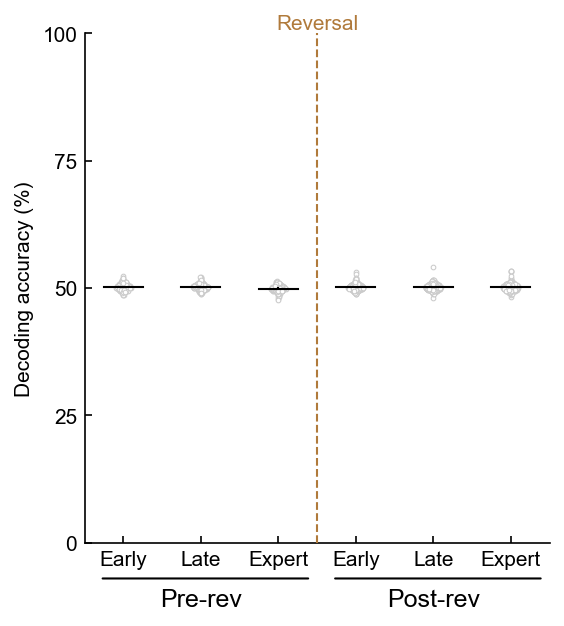

In [36]:
#Firing rate modulation graphs

size=5

#FRmod_baseline_median = np.nanmedian(np.abs(FRmod_preearly))
#print('baseline = '+str(FRmod_baseline_median))

fig, ax = plt.subplots(figsize=(4,4.5))
# fig, ax = plt.subplots(figsize=(5,3))
data = [Stim_Shuffled_Dec_preearly,Stim_Shuffled_Dec_prelate,Stim_Shuffled_Dec_preexpert,Stim_Shuffled_Dec_postearly,Stim_Shuffled_Dec_postlate,Stim_Shuffled_Dec_postexpert]
data = [np.abs(column[np.isfinite(column)]) for column in data]
#num_animal = [preearly_animal_num,prelate_animal_num,preexpert_animal_num,postearly_animal_num,postlate_animal_num,postexpert_animal_num]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.25)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.25)
colors = NCR_CR_cmap((Y-1)/5)

ax.scatter(X, Y, s=size, ec=GOOD_GREY, fc='white', lw=0.5,zorder=-10)
#ax.set_yscale('log',subs=[])

#Plot summary
for idx,column in enumerate(data):    
    eye_color=GOOD_GREY#NCR_CR_cmap((percentCR-40)/20)
    
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    #border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    border_color=colorsys.hls_to_rgb(h,l,s)

    summary_size=50
    summary_width=1
    
    #Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    mean = np.mean(column)
    SEM = sem(column)
    Q1 = mean-SEM
    Q3 = mean+SEM
    
#     ax.scatter([idx], [mean], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
#     ax.plot([idx, idx], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
    width=0.25
    ax.plot([idx-width,idx+width],[mean]*2,color='k',lw=1)
    ax.plot([idx]*2,[mean-SEM,mean+SEM],color='k',lw=1)

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)

ax.set_ylim([0,1])
ax.set_yticks([0,0.25,0.5,0.75,1])
ax.set_yticklabels(['0','25','50','75','100'])
ax.set_ylabel('Decoding accuracy (%)')

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())

    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.5,zorder=-5)
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')


#NORMAL
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, -0.13304656298982956/1.5, 'Pre-rev', ha='center', va='top', fontsize=12)
ax.text(xtick_pos_post, -0.13304656298982956/1.5, 'Post-rev', ha='center', va='top',  fontsize=12)
ax.annotate('', xy=(0.03, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(0.99, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Stimulus shuffled decoding mean performance over phases V'+str(current_version)+'.pdf'),transparent=False,facecolor="white")

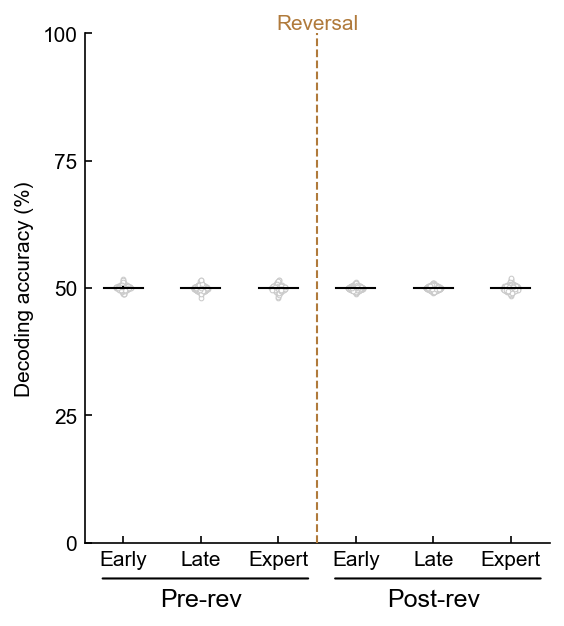

In [12]:
#Firing rate modulation graphs

size=5

#FRmod_baseline_median = np.nanmedian(np.abs(FRmod_preearly))
#print('baseline = '+str(FRmod_baseline_median))

fig, ax = plt.subplots(figsize=(4,4.5))
# fig, ax = plt.subplots(figsize=(5,3))
data = [Stim_Synthetic_Dec_preearly,Stim_Synthetic_Dec_prelate,Stim_Synthetic_Dec_preexpert,Stim_Synthetic_Dec_postearly,Stim_Synthetic_Dec_postlate,Stim_Synthetic_Dec_postexpert]
data = [np.abs(column[np.isfinite(column)]) for column in data]
#num_animal = [preearly_animal_num,prelate_animal_num,preexpert_animal_num,postearly_animal_num,postlate_animal_num,postexpert_animal_num]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.25)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.25)
colors = NCR_CR_cmap((Y-1)/5)

ax.scatter(X, Y, s=size, ec=GOOD_GREY, fc='white', lw=0.5,zorder=-10)
#ax.set_yscale('log',subs=[])

#Plot summary
for idx,column in enumerate(data):    
    eye_color=GOOD_GREY#NCR_CR_cmap((percentCR-40)/20)
    
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    #border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    border_color=colorsys.hls_to_rgb(h,l,s)

    summary_size=50
    summary_width=1
    
    #Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    mean = np.mean(column)
    SEM = sem(column)
    Q1 = mean-SEM
    Q3 = mean+SEM
    
#     ax.scatter([idx], [mean], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
#     ax.plot([idx, idx], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
    width=0.25
    ax.plot([idx-width,idx+width],[mean]*2,color='k',lw=1)
    ax.plot([idx]*2,[mean-SEM,mean+SEM],color='k',lw=1)

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)

ax.set_ylim([0,1])
ax.set_yticks([0,0.25,0.5,0.75,1])
ax.set_yticklabels(['0','25','50','75','100'])
ax.set_ylabel('Decoding accuracy (%)')

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())

    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.5,zorder=-5)
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')


#NORMAL
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, -0.13304656298982956/1.5, 'Pre-rev', ha='center', va='top', fontsize=12)
ax.text(xtick_pos_post, -0.13304656298982956/1.5, 'Post-rev', ha='center', va='top',  fontsize=12)
ax.annotate('', xy=(0.03, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(0.99, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Stimulus synthetic decoding mean performance over phases V'+str(current_version)+'.pdf'),transparent=False,facecolor="white")

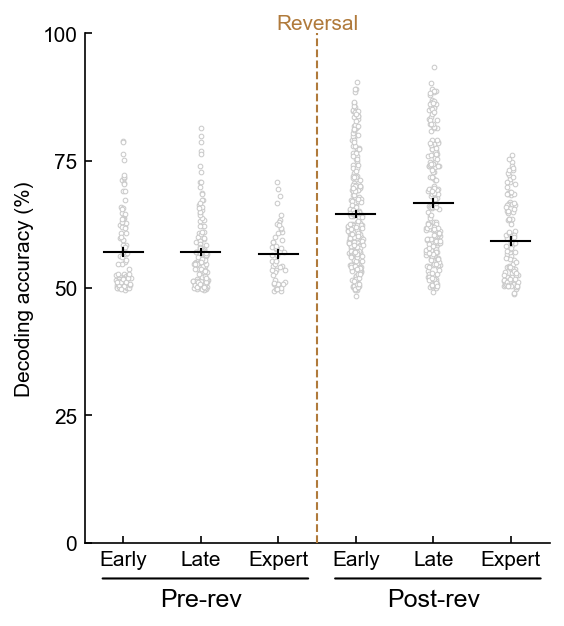

In [38]:
#Firing rate modulation graphs

size=5

#FRmod_baseline_median = np.nanmedian(np.abs(FRmod_preearly))
#print('baseline = '+str(FRmod_baseline_median))

fig, ax = plt.subplots(figsize=(4,4.5))
# fig, ax = plt.subplots(figsize=(5,3))
data = [Choice_Shuffled_Dec_preearly,Choice_Shuffled_Dec_prelate,Choice_Shuffled_Dec_preexpert,Choice_Shuffled_Dec_postearly,Choice_Shuffled_Dec_postlate,Choice_Shuffled_Dec_postexpert]
data = [np.abs(column[np.isfinite(column)]) for column in data]
#num_animal = [preearly_animal_num,prelate_animal_num,preexpert_animal_num,postearly_animal_num,postlate_animal_num,postexpert_animal_num]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.25)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.25)
colors = NCR_CR_cmap((Y-1)/5)

ax.scatter(X, Y, s=size, ec=GOOD_GREY, fc='white', lw=0.5,zorder=-10)
#ax.set_yscale('log',subs=[])

#Plot summary
for idx,column in enumerate(data):    
    eye_color=GOOD_GREY#NCR_CR_cmap((percentCR-40)/20)
    
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    #border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    border_color=colorsys.hls_to_rgb(h,l,s)

    summary_size=50
    summary_width=1
    
    #Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    mean = np.mean(column)
    SEM = sem(column)
    Q1 = mean-SEM
    Q3 = mean+SEM
    
#     ax.scatter([idx], [mean], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
#     ax.plot([idx, idx], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
    width=0.25
    ax.plot([idx-width,idx+width],[mean]*2,color='k',lw=1)
    ax.plot([idx]*2,[mean-SEM,mean+SEM],color='k',lw=1)

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)

ax.set_ylim([0,1])
ax.set_yticks([0,0.25,0.5,0.75,1])
ax.set_yticklabels(['0','25','50','75','100'])
ax.set_ylabel('Decoding accuracy (%)')

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())

    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.5,zorder=-5)
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')


#NORMAL
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, -0.13304656298982956/1.5, 'Pre-rev', ha='center', va='top', fontsize=12)
ax.text(xtick_pos_post, -0.13304656298982956/1.5, 'Post-rev', ha='center', va='top',  fontsize=12)
ax.annotate('', xy=(0.03, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(0.99, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Choice shuffled decoding mean performance over phases V'+str(current_version)+'.pdf'),transparent=False,facecolor="white")

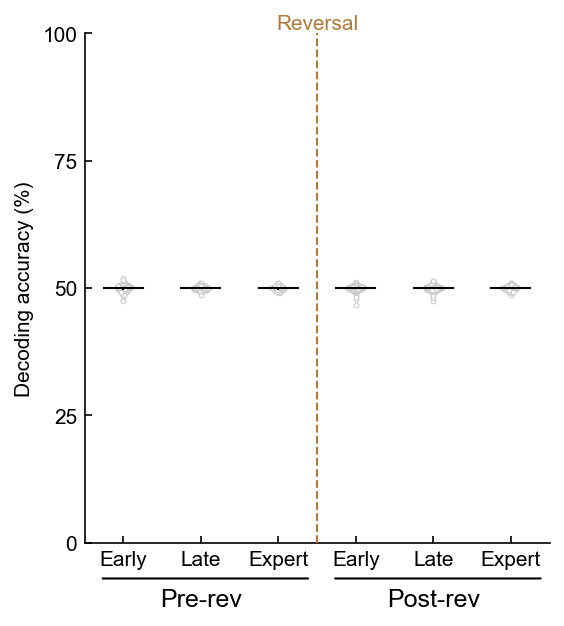

In [18]:
#Firing rate modulation graphs

size=5

#FRmod_baseline_median = np.nanmedian(np.abs(FRmod_preearly))
#print('baseline = '+str(FRmod_baseline_median))

fig, ax = plt.subplots(figsize=(4,4.5))
# fig, ax = plt.subplots(figsize=(5,3))
data = [Choice_Synthetic_Dec_preearly,Choice_Synthetic_Dec_prelate,Choice_Synthetic_Dec_preexpert,Choice_Synthetic_Dec_postearly,Choice_Synthetic_Dec_postlate,Choice_Synthetic_Dec_postexpert]
data = [np.abs(column[np.isfinite(column)]) for column in data]
#num_animal = [preearly_animal_num,prelate_animal_num,preexpert_animal_num,postearly_animal_num,postlate_animal_num,postexpert_animal_num]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.25)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.25)
colors = NCR_CR_cmap((Y-1)/5)

ax.scatter(X, Y, s=size, ec=GOOD_GREY, fc='white', lw=0.5,zorder=-10)
#ax.set_yscale('log',subs=[])

#Plot summary
for idx,column in enumerate(data):    
    eye_color=GOOD_GREY#NCR_CR_cmap((percentCR-40)/20)
    
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    #border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    border_color=colorsys.hls_to_rgb(h,l,s)

    summary_size=50
    summary_width=1
    
    #Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    mean = np.mean(column)
    SEM = sem(column)
    Q1 = mean-SEM
    Q3 = mean+SEM
    
#     ax.scatter([idx], [mean], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
#     ax.plot([idx, idx], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
    width=0.25
    ax.plot([idx-width,idx+width],[mean]*2,color='k',lw=1)
    ax.plot([idx]*2,[mean-SEM,mean+SEM],color='k',lw=1)

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)

ax.set_ylim([0,1])
ax.set_yticks([0,0.25,0.5,0.75,1])
ax.set_yticklabels(['0','25','50','75','100'])
ax.set_ylabel('Decoding accuracy (%)')

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())

    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.5,zorder=-5)
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')


#NORMAL
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, -0.13304656298982956/1.5, 'Pre-rev', ha='center', va='top', fontsize=12)
ax.text(xtick_pos_post, -0.13304656298982956/1.5, 'Post-rev', ha='center', va='top',  fontsize=12)
ax.annotate('', xy=(0.03, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(0.99, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Choice synthetic decoding mean performance over phases V'+str(current_version)+'.pdf'),transparent=False,facecolor="white")

In [21]:
Stim_Dec_preearly

array([0.5614236 , 0.52262944, 0.57750307,        nan,        nan,
       0.49227604, 0.48350023, 0.53297956, 0.46722786, 0.53154731,
       0.53623601, 0.57218789,        nan,        nan,        nan,
              nan, 0.46606628, 0.54549885,        nan, 0.48337405,
              nan, 0.52708833, 0.47721106,        nan,        nan,
       0.52661849, 0.53680314, 0.49464491, 0.53096449, 0.5471673 ,
              nan, 0.52194604,        nan, 0.47732162,        nan,
       0.55716173, 0.53761743,        nan, 0.45984033, 0.54850904,
              nan,        nan,        nan, 0.57466562,        nan,
       0.46637337,        nan,        nan, 0.56233641, 0.53678821,
              nan, 0.43525194, 0.51927166, 0.61870748, 0.60272383,
       0.6530691 , 0.55039843, 0.47115038, 0.53831014, 0.4830843 ,
       0.54477235, 0.57669989, 0.52912702, 0.51976464, 0.63291395,
       0.51951145, 0.57185665, 0.52130684,        nan,        nan,
       0.4330023 , 0.53052728,        nan,        nan, 0.44351

# Boxplots

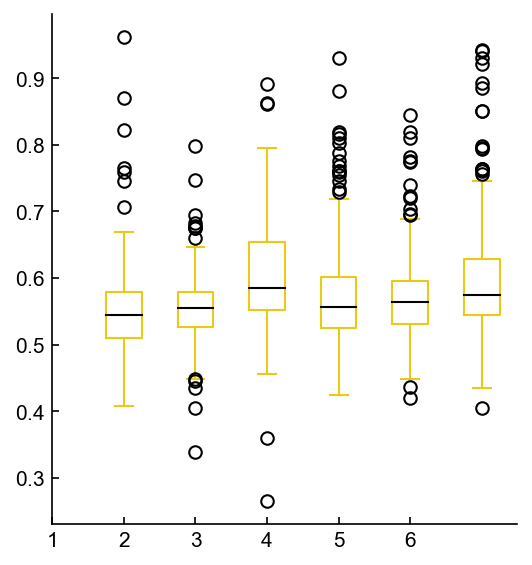

In [51]:
fig, ax = plt.subplots(figsize=(4,4.5))

stim_data = [Stim_Dec_preearly,Stim_Dec_prelate,Stim_Dec_preexpert,Stim_Dec_postearly,Stim_Dec_postlate,Stim_Dec_postexpert]
stim_data = [ilep.rmnan(d) for d in stim_data]

boxprops = dict(linestyle='-', linewidth=1, color=STIM_COLOR)
whiskerprops = dict(linestyle='-', linewidth=1, color=STIM_COLOR)
capprops = dict(linestyle='-', linewidth=1, color=STIM_COLOR)
medianprops = dict(linestyle='-', linewidth=1, color='k')
figdata = ax.boxplot(stim_data,boxprops=boxprops,medianprops=medianprops,whiskerprops=whiskerprops,capprops=capprops)

ax.set_xticks(range(6))

# Stacked decoding plot

<ipython-input-97-bd5170bed882>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stim_dec = np.array([Stim_Dec_preearly,Stim_Dec_prelate,Stim_Dec_preexpert,Stim_Dec_postearly,Stim_Dec_postlate,Stim_Dec_postexpert])*100
<ipython-input-97-bd5170bed882>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stim_dec_control = np.array([Control_Stim_Dec_preearly,Control_Stim_Dec_prelate,Control_Stim_Dec_preexpert,Control_Stim_Dec_postearly,Control_Stim_Dec_postlate,Control_Stim_Dec_postexpert])*100
<ipython-input-97-bd5170bed882>:13: VisibleDeprecationWarning

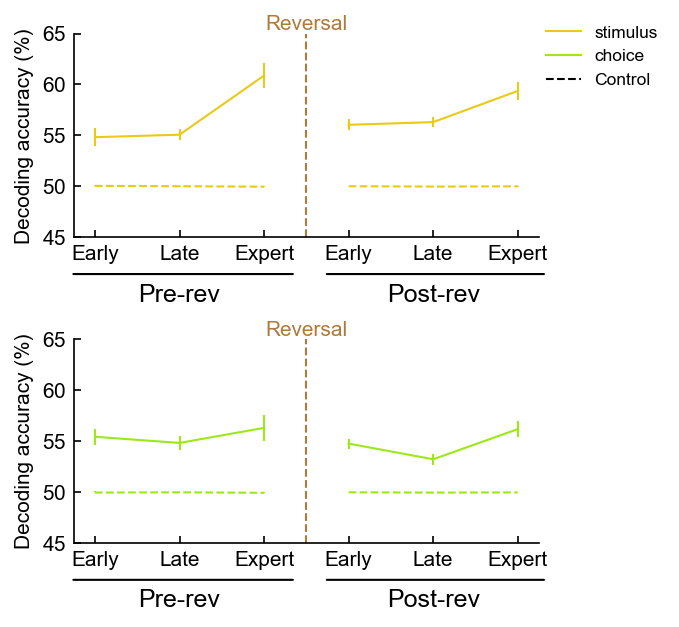

In [97]:
fig = plt.figure(figsize=(4,4.5))
gs = fig.add_gridspec(2,1,wspace=0.25,hspace=0.5)
axs = [plt.subplot(gs[i,j]) for i,j in product(range(2),range(1))]
labels = ['Early','Late','Expert','Early','Late','Expert']

#choice_dec = [Choice_Dec_preearly,Choice_Dec_prelate,Choice_Dec_preexpert,Choice_Dec_postearly,Choice_Dec_postlate,Choice_Dec_postexpert]

stim_dec = np.array([Stim_Dec_preearly,Stim_Dec_prelate,Stim_Dec_preexpert,Stim_Dec_postearly,Stim_Dec_postlate,Stim_Dec_postexpert])*100
stim_dec = [ilep.rmnan(d) for d in stim_dec]
stim_dec_control = np.array([Control_Stim_Dec_preearly,Control_Stim_Dec_prelate,Control_Stim_Dec_preexpert,Control_Stim_Dec_postearly,Control_Stim_Dec_postlate,Control_Stim_Dec_postexpert])*100
stim_dec_control = [ilep.rmnan(d) for d in stim_dec_control]

choice_dec = np.array([Choice_Dec_preearly,Choice_Dec_prelate,Choice_Dec_preexpert,Choice_Dec_postearly,Choice_Dec_postlate,Choice_Dec_postexpert])*100
choice_dec = [ilep.rmnan(d) for d in choice_dec]
choice_dec_control = np.array([Control_Choice_Dec_preearly,Control_Choice_Dec_prelate,Control_Choice_Dec_preexpert,Control_Choice_Dec_postearly,Control_Choice_Dec_postlate,Control_Choice_Dec_postexpert])*100
choice_dec_control = [ilep.rmnan(d) for d in choice_dec_control]

# axs[0].plot(range(6),stim_dec)
# axs[0].errorbar(range(6),stim_dec,yerr=stim_dec_sem,elinewidth=10,lw=0)

for idx,column in enumerate(stim_dec):
    mean = np.mean(column)
    SEM = sem(column)
    Q1 = mean-SEM
    Q3 = mean+SEM
#     print(f"{Q1},{mean},{Q3}")
    axs[0].plot([idx]*2,[mean-SEM,mean+SEM],color=STIM_COLOR,lw=1)
axs[0].plot([0,1,2],[np.nanmean(d) for d in stim_dec[0:3]],color=STIM_COLOR,lw=1)
axs[0].plot([3,4,5],[np.nanmean(d) for d in stim_dec[3:6]],color=STIM_COLOR,lw=1)
for idx,column in enumerate(stim_dec_control):
    mean = np.mean(column)
    SEM = sem(column)
    Q1 = mean-SEM
    Q3 = mean+SEM
#     print(f"{Q1},{mean},{Q3}")
    axs[0].plot([idx]*2,[mean-SEM,mean+SEM],color=STIM_COLOR,linestyle='--',lw=1)
axs[0].plot([0,1,2],[np.nanmean(d) for d in stim_dec_control[0:3]],color=STIM_COLOR,linestyle='--',lw=1)
axs[0].plot([3,4,5],[np.nanmean(d) for d in stim_dec_control[3:6]],color=STIM_COLOR,linestyle='--',lw=1)



for idx,column in enumerate(choice_dec):
    mean = np.mean(column)
    SEM = sem(column)
    Q1 = mean-SEM
    Q3 = mean+SEM
#     print(f"{Q1},{mean},{Q3}")
    axs[1].plot([idx]*2,[mean-SEM,mean+SEM],color=CHOICE_COLOR,lw=1)
axs[1].plot([0,1,2],[np.nanmean(d) for d in choice_dec[0:3]],color=CHOICE_COLOR,lw=1)
axs[1].plot([3,4,5],[np.nanmean(d) for d in choice_dec[3:6]],color=CHOICE_COLOR,lw=1)
for idx,column in enumerate(stim_dec_control):
    mean = np.mean(column)
    SEM = sem(column)
    Q1 = mean-SEM
    Q3 = mean+SEM
#     print(f"{Q1},{mean},{Q3}")
    axs[1].plot([idx]*2,[mean-SEM,mean+SEM],color=CHOICE_COLOR,linestyle='--',lw=1)
axs[1].plot([0,1,2],[np.nanmean(d) for d in choice_dec_control[0:3]],color=CHOICE_COLOR,linestyle='--',lw=1)
axs[1].plot([3,4,5],[np.nanmean(d) for d in choice_dec_control[3:6]],color=CHOICE_COLOR,linestyle='--',lw=1)


for ax in axs:
    ax.set_ylim([45,65])
    ax.set_ylabel('Decoding accuracy (%)')
    
    ax.set_xticks(range(6))
    ax.set_xticklabels(labels)
    
    ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=-10,lw=1)
    ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')
    
    xtick_pos_pre = ax.get_xticks()[1]
    xtick_pos_post = ax.get_xticks()[4]
    Yval = ilep.getPrePostLabelYval(ax.get_ylim())-2
    t1 = ax.text(xtick_pos_pre, Yval, 'Pre-rev', ha='center', va='top', fontsize=12,color='k')
    t2 = ax.text(xtick_pos_post, Yval, 'Post-rev', ha='center', va='top',  fontsize=12,color='k')
    ax.annotate('', xy=(-0.01, -0.18), xycoords='axes fraction', xytext=(0.48, -0.18),arrowprops=dict(arrowstyle='-', color='black'))
    ax.annotate('', xy=(0.535, -0.18), xycoords='axes fraction', xytext=(1.02, -0.18),arrowprops=dict(arrowstyle='-', color='black'))

axs[0].plot([],[],color=STIM_COLOR,lw=1,label='stimulus')
axs[0].plot([],[],color=CHOICE_COLOR,lw=1,label='choice')
axs[0].plot([],[],color='k',linestyle='--',lw=1,label='Control')
lgd = axs[0].legend(frameon=False,loc=(1,0.7))

fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Decoding performance over phases V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=(lgd,), bbox_inches='tight')

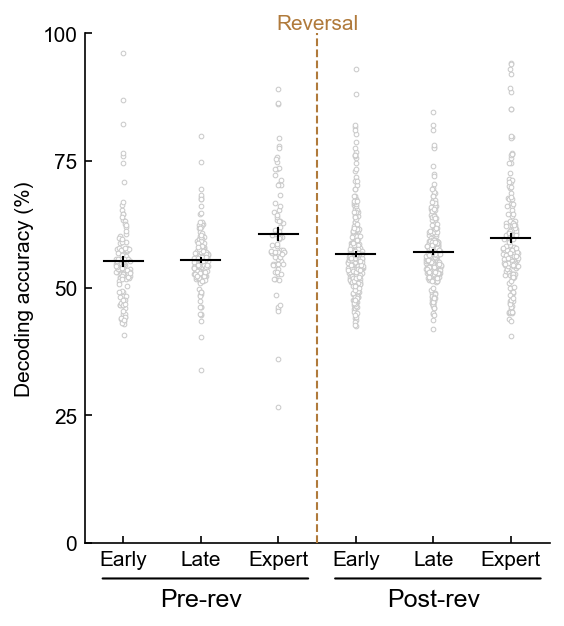

In [10]:
#Firing rate modulation graphs

size=5

#FRmod_baseline_median = np.nanmedian(np.abs(FRmod_preearly))
#print('baseline = '+str(FRmod_baseline_median))

fig, ax = plt.subplots(figsize=(4,4.5))
# fig, ax = plt.subplots(figsize=(5,3))
data = [Stim_Dec_preearly,Stim_Dec_prelate,Stim_Dec_preexpert,Stim_Dec_postearly,Stim_Dec_postlate,Stim_Dec_postexpert]
data = [np.abs(column[np.isfinite(column)]) for column in data]
#num_animal = [preearly_animal_num,prelate_animal_num,preexpert_animal_num,postearly_animal_num,postlate_animal_num,postexpert_animal_num]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.25)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.25)
colors = NCR_CR_cmap((Y-1)/5)

ax.scatter(X, Y, s=size, ec=GOOD_GREY, fc='white', lw=0.5,zorder=-10)
#ax.set_yscale('log',subs=[])

#Plot summary
for idx,column in enumerate(data):    
    eye_color=GOOD_GREY#NCR_CR_cmap((percentCR-40)/20)
    
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    #border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    border_color=colorsys.hls_to_rgb(h,l,s)

    summary_size=50
    summary_width=1
    
    #Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    mean = np.mean(column)
    SEM = sem(column)
    Q1 = mean-SEM
    Q3 = mean+SEM
    
#     ax.scatter([idx], [mean], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
#     ax.plot([idx, idx], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
    width=0.25
    ax.plot([idx-width,idx+width],[mean]*2,color='k',lw=1)
    ax.plot([idx]*2,[mean-SEM,mean+SEM],color='k',lw=1)

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)

ax.set_ylim([0,1])
ax.set_yticks([0,0.25,0.5,0.75,1])
ax.set_yticklabels(['0','25','50','75','100'])
ax.set_ylabel('Decoding accuracy (%)')

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())

    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.5,zorder=-5)
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')


#NORMAL
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, -0.13304656298982956/1.5, 'Pre-rev', ha='center', va='top', fontsize=12)
ax.text(xtick_pos_post, -0.13304656298982956/1.5, 'Post-rev', ha='center', va='top',  fontsize=12)
ax.annotate('', xy=(0.03, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(0.99, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Stimulus decoding mean performance over phases V'+str(current_version)+'.pdf'),transparent=False,facecolor="white")

# Paired Stim / Choice Decoding

In [100]:
Stim_acc_list = [Stim_Dec_preearly,Stim_Dec_prelate,Stim_Dec_preexpert,Stim_Dec_postearly,Stim_Dec_postlate,Stim_Dec_postexpert]
Choice_acc_list = [Choice_Dec_preearly,Choice_Dec_prelate,Choice_Dec_preexpert,Choice_Dec_postearly,Choice_Dec_postlate,Choice_Dec_postexpert]
Control_Stim_acc_list = [Control_Stim_Dec_preearly,Control_Stim_Dec_prelate,Control_Stim_Dec_preexpert,Control_Stim_Dec_postearly,Control_Stim_Dec_postlate,Control_Stim_Dec_postexpert]
Control_Choice_acc_list = [Control_Choice_Dec_preearly,Control_Choice_Dec_prelate,Control_Choice_Dec_preexpert,Control_Choice_Dec_postearly,Control_Choice_Dec_postlate,Control_Choice_Dec_postexpert]

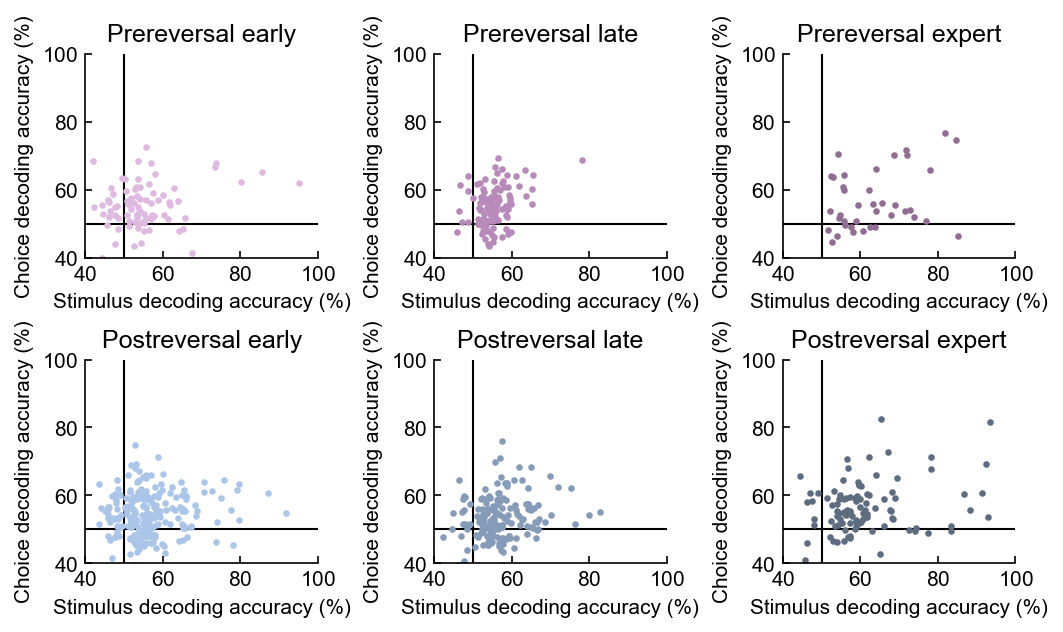

In [135]:
fig = plt.figure(figsize=(8,4.5))
gs = fig.add_gridspec(2,3,wspace=0.5,hspace=0.5)
axs = [plt.subplot(gs[i,j]) for i,j in product(range(2),range(3))]
labels = ['Prereversal early','Prereversal late','Prereversal expert','Postreversal early','Postreversal late','Postreversal expert']

for idx,(stim,choice,ax,label) in enumerate(zip(Stim_acc_list,Choice_acc_list,axs,labels)):
    ax.scatter(stim*100,choice*100,s=10,lw=0,c=PHASE_COLORS[idx])
    ax.axvline(50,linestyle='-',lw=1,c='k',zorder=-10)
    ax.axhline(50,linestyle='-',lw=1,c='k',zorder=-10)
    
    ax.set_xlim([40,100])
    ax.set_xlabel('Stimulus decoding accuracy (%)')
    
    ax.set_ylim([40,100])
    ax.set_ylabel('Choice decoding accuracy (%)')
    
    ax.set_title(label)
    
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Paired stim choice decoding accuracy V'+str(current_version)+'.pdf'),transparent=False,facecolor="white")

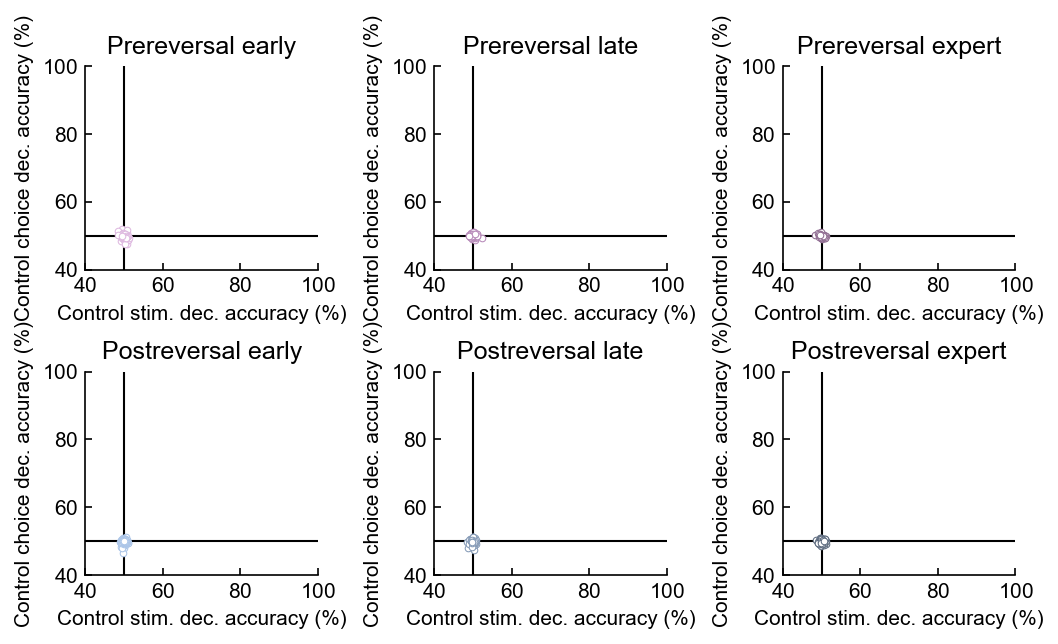

In [136]:
fig = plt.figure(figsize=(8,4.5))
gs = fig.add_gridspec(2,3,wspace=0.5,hspace=0.5)
axs = [plt.subplot(gs[i,j]) for i,j in product(range(2),range(3))]
labels = ['Prereversal early','Prereversal late','Prereversal expert','Postreversal early','Postreversal late','Postreversal expert']

for idx,(stim,choice,ax,label) in enumerate(zip(Control_Stim_acc_list,Control_Choice_acc_list,axs,labels)):
    ax.scatter(stim*100,choice*100,s=10,fc='white',ec=PHASE_COLORS[idx],lw=0.5)
    ax.axvline(50,linestyle='-',lw=1,c='k',zorder=-10)
    ax.axhline(50,linestyle='-',lw=1,c='k',zorder=-10)
    
    ax.set_xlim([40,100])
    ax.set_xlabel('Control stim. dec. accuracy (%)')
    
    ax.set_ylim([40,100])
    ax.set_ylabel('Control choice dec. accuracy (%)')
    
    ax.set_title(label)
    
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Paired stim choice control decoding accuracy V'+str(current_version)+'.pdf'),transparent=False,facecolor="white")

# Decoding over learning separated by CR / NCR

In [142]:
CR_Stim_Dec_preearly = []
CR_Stim_Dec_prelate = []
CR_Stim_Dec_preexpert = []
CR_Stim_Dec_postearly = []
CR_Stim_Dec_postlate = []
CR_Stim_Dec_postexpert = []

NCR_Stim_Dec_preearly = []
NCR_Stim_Dec_prelate = []
NCR_Stim_Dec_preexpert = []
NCR_Stim_Dec_postearly = []
NCR_Stim_Dec_postlate = []
NCR_Stim_Dec_postexpert = []

CR_Choice_Dec_preearly = []
CR_Choice_Dec_prelate = []
CR_Choice_Dec_preexpert = []
CR_Choice_Dec_postearly = []
CR_Choice_Dec_postlate = []
CR_Choice_Dec_postexpert = []

NCR_Choice_Dec_preearly = []
NCR_Choice_Dec_prelate = []
NCR_Choice_Dec_preexpert = []
NCR_Choice_Dec_postearly = []
NCR_Choice_Dec_postlate = []
NCR_Choice_Dec_postexpert = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
    
    stim_acc = getDataPoint(dec_df,session,clust,'stimulus','weighted_accuracy')
    choice_acc = getDataPoint(dec_df,session,clust,'response','weighted_accuracy')
    stim_acc_control = getDataPoint(dec_df,session,clust,'stimulus','synthetic_control_weighted_accuracy')
    choice_acc_control = getDataPoint(dec_df,session,clust,'response','synthetic_control_weighted_accuracy')
    
    if getDataPoint(dec_df,session,clust,'stimulus','pval_synthetic_control') > 0.05:
        stim_acc = np.nan
    if getDataPoint(dec_df,session,clust,'response','pval_synthetic_control') > 0.05:
        choice_acc = np.nan
        
    if EILphases[idx] not in ['pre expert','post expert'] and sessionfile.meta.animal in ['DS_15','DS_19']:
        continue
    
    if EILphases[idx] == 'pre early':
        if FRmod >= 3.5:
            CR_Stim_Dec_preearly.append(stim_acc)
            CR_Choice_Dec_preearly.append(choice_acc)
        else:
            NCR_Stim_Dec_preearly.append(stim_acc)
            NCR_Choice_Dec_preearly.append(choice_acc)
    elif EILphases[idx] == 'pre late':
        if FRmod >= 3.5:
            CR_Stim_Dec_prelate.append(stim_acc)
            CR_Choice_Dec_prelate.append(choice_acc)
        else:
            NCR_Stim_Dec_prelate.append(stim_acc)
            NCR_Choice_Dec_prelate.append(choice_acc)
    elif EILphases[idx] == 'pre expert':
        if FRmod >= 3.5:
            CR_Stim_Dec_preexpert.append(stim_acc)
            CR_Choice_Dec_preexpert.append(choice_acc)
        else:
            NCR_Stim_Dec_preexpert.append(stim_acc)
            NCR_Choice_Dec_preexpert.append(choice_acc)
    elif EILphases[idx] == 'post early':
        if FRmod >= 3.5:
            CR_Stim_Dec_postearly.append(stim_acc)
            CR_Choice_Dec_postearly.append(choice_acc)
        else:
            NCR_Stim_Dec_postearly.append(stim_acc)
            NCR_Choice_Dec_postearly.append(choice_acc)
    elif EILphases[idx] == 'post late':
        if FRmod >= 3.5:
            CR_Stim_Dec_postlate.append(stim_acc)
            CR_Choice_Dec_postlate.append(choice_acc)
        else:
            NCR_Stim_Dec_postlate.append(stim_acc)
            NCR_Choice_Dec_postlate.append(choice_acc)
    elif EILphases[idx] == 'post expert':
        if FRmod >= 3.5:
            CR_Stim_Dec_postexpert.append(stim_acc)
            CR_Choice_Dec_postexpert.append(choice_acc)
        else:
            NCR_Stim_Dec_postexpert.append(stim_acc)
            NCR_Choice_Dec_postexpert.append(choice_acc)
        
CR_Stim_Dec_preearly = np.array(CR_Stim_Dec_preearly)
CR_Stim_Dec_prelate = np.array(CR_Stim_Dec_prelate)
CR_Stim_Dec_preexpert = np.array(CR_Stim_Dec_preexpert)
CR_Stim_Dec_postearly = np.array(CR_Stim_Dec_postearly)
CR_Stim_Dec_postlate = np.array(CR_Stim_Dec_postlate)
CR_Stim_Dec_postexpert = np.array(CR_Stim_Dec_postexpert)

NCR_Stim_Dec_preearly = np.array(NCR_Stim_Dec_preearly)
NCR_Stim_Dec_prelate = np.array(NCR_Stim_Dec_prelate)
NCR_Stim_Dec_preexpert = np.array(NCR_Stim_Dec_preexpert)
NCR_Stim_Dec_postearly = np.array(NCR_Stim_Dec_postearly)
NCR_Stim_Dec_postlate = np.array(NCR_Stim_Dec_postlate)
NCR_Stim_Dec_postexpert = np.array(NCR_Stim_Dec_postexpert)

CR_Choice_Dec_preearly = np.array(CR_Choice_Dec_preearly)
CR_Choice_Dec_prelate = np.array(CR_Choice_Dec_prelate)
CR_Choice_Dec_preexpert = np.array(CR_Choice_Dec_preexpert)
CR_Choice_Dec_postearly = np.array(CR_Choice_Dec_postearly)
CR_Choice_Dec_postlate = np.array(CR_Choice_Dec_postlate)
CR_Choice_Dec_postexpert = np.array(CR_Choice_Dec_postexpert)

NCR_Choice_Dec_preearly = np.array(NCR_Choice_Dec_preearly)
NCR_Choice_Dec_prelate = np.array(NCR_Choice_Dec_prelate)
NCR_Choice_Dec_preexpert = np.array(NCR_Choice_Dec_preexpert)
NCR_Choice_Dec_postearly = np.array(NCR_Choice_Dec_postearly)
NCR_Choice_Dec_postlate = np.array(NCR_Choice_Dec_postlate)
NCR_Choice_Dec_postexpert = np.array(NCR_Choice_Dec_postexpert)

1682it [00:32, 52.41it/s] 


In [143]:
CR_Stim_acc_list = [CR_Stim_Dec_preearly,CR_Stim_Dec_prelate,CR_Stim_Dec_preexpert,CR_Stim_Dec_postearly,CR_Stim_Dec_postlate,CR_Stim_Dec_postexpert]
CR_Choice_acc_list = [CR_Choice_Dec_preearly,CR_Choice_Dec_prelate,CR_Choice_Dec_preexpert,CR_Choice_Dec_postearly,CR_Choice_Dec_postlate,CR_Choice_Dec_postexpert]
NCR_Stim_acc_list = [NCR_Stim_Dec_preearly,NCR_Stim_Dec_prelate,NCR_Stim_Dec_preexpert,NCR_Stim_Dec_postearly,NCR_Stim_Dec_postlate,NCR_Stim_Dec_postexpert]
NCR_Choice_acc_list = [NCR_Choice_Dec_preearly,NCR_Choice_Dec_prelate,NCR_Choice_Dec_preexpert,NCR_Choice_Dec_postearly,NCR_Choice_Dec_postlate,NCR_Choice_Dec_postexpert]

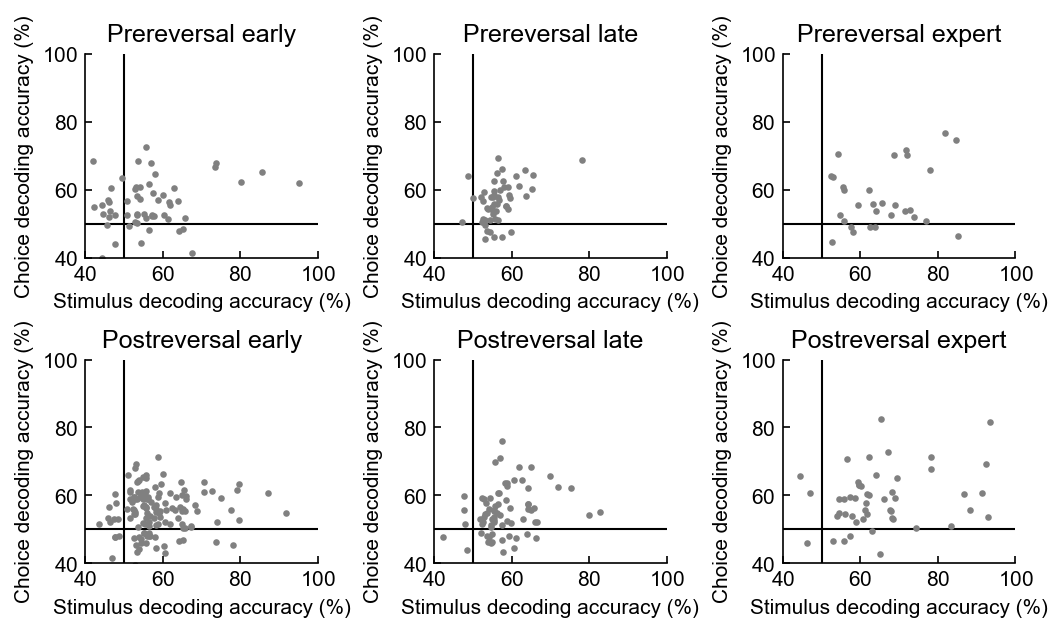

In [147]:
fig = plt.figure(figsize=(8,4.5))
gs = fig.add_gridspec(2,3,wspace=0.5,hspace=0.5)
axs = [plt.subplot(gs[i,j]) for i,j in product(range(2),range(3))]
labels = ['Prereversal early','Prereversal late','Prereversal expert','Postreversal early','Postreversal late','Postreversal expert']

for idx,(stim,choice,ax,label) in enumerate(zip(CR_Stim_acc_list,CR_Choice_acc_list,axs,labels)):
    ax.scatter(stim*100,choice*100,s=10,lw=0,c=CR_COLOR)
    ax.axvline(50,linestyle='-',lw=1,c='k',zorder=-10)
    ax.axhline(50,linestyle='-',lw=1,c='k',zorder=-10)
    
    ax.set_xlim([40,100])
    ax.set_xlabel('Stimulus decoding accuracy (%)')
    
    ax.set_ylim([40,100])
    ax.set_ylabel('Choice decoding accuracy (%)')
    
    ax.set_title(label)
    
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','CR Paired stim choice decoding accuracy V'+str(current_version)+'.pdf'),transparent=False,facecolor="white")

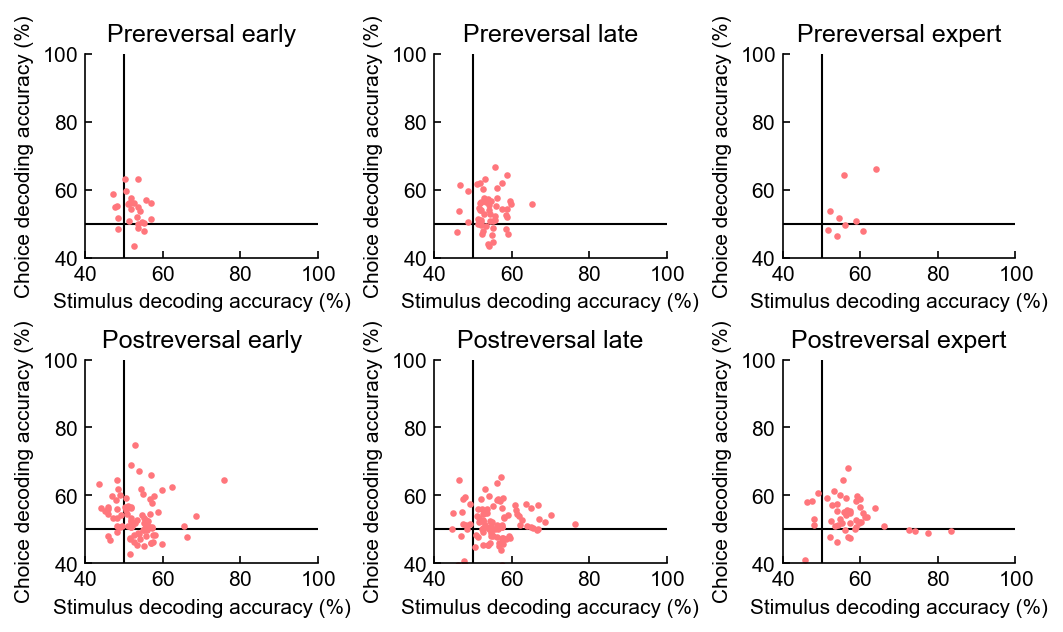

In [148]:
fig = plt.figure(figsize=(8,4.5))
gs = fig.add_gridspec(2,3,wspace=0.5,hspace=0.5)
axs = [plt.subplot(gs[i,j]) for i,j in product(range(2),range(3))]
labels = ['Prereversal early','Prereversal late','Prereversal expert','Postreversal early','Postreversal late','Postreversal expert']

for idx,(stim,choice,ax,label) in enumerate(zip(NCR_Stim_acc_list,NCR_Choice_acc_list,axs,labels)):
    ax.scatter(stim*100,choice*100,s=10,lw=0,c=NCR_COLOR)
    ax.axvline(50,linestyle='-',lw=1,c='k',zorder=-10)
    ax.axhline(50,linestyle='-',lw=1,c='k',zorder=-10)
    
    ax.set_xlim([40,100])
    ax.set_xlabel('Stimulus decoding accuracy (%)')
    
    ax.set_ylim([40,100])
    ax.set_ylabel('Choice decoding accuracy (%)')
    
    ax.set_title(label)
    
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','NCR Paired stim choice decoding accuracy V'+str(current_version)+'.pdf'),transparent=False,facecolor="white")

# Passive decoding

In [10]:
animals_in_cache = []

EnumACSession = []
EnumACClust = []

for session in tqdm(os.listdir(act_directory)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.animal not in ['TH_201','TH_203','LA_204','LA_205','TH_200', 'TH_230','AE_229','TH_233','TH_234']:
        continue
    
    animals_in_cache.append(sessionfile.meta.animal)
    
    for clust in sessionfile.clusters.good:
        if sessionfile.meta.region == "AC":
            EnumACSession.append(session)
            EnumACClust.append(clust)
        
animals_in_cache = np.unique(animals_in_cache)

100%|██████████| 723/723 [00:04<00:00, 147.84it/s]


In [11]:
#Define 6 learning phases(days)
pre_early = 4
pre_late = 6
pre_expert = 8
post_early = 12
post_late = 15
post_expert = 16

#
passive_FRmod_preearly = []
passive_FRmod_prelate = []
passive_FRmod_preexpert = []
passive_FRmod_postearly = []
passive_FRmod_postlate = []
passive_FRmod_postexpert = []

#
preexpert_session_num = []
postlate_session_num = []
postexpert_session_num = []


In [12]:
preearly_animal = []
prelate_animal = []
preexpert_animal = []
postearly_animal = []
postlate_animal = []
postexpert_animal = []

pre_early_session = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumACSession,EnumACClust))):
    ACsessionfile = ilep.loadSessionCached(act_directory,session)
    
    #1,2,3,4
    if ACsessionfile.meta.day_of_training <= pre_early:
        passive_FRmod_preearly.append(ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        preearly_animal.append(ACsessionfile.meta.animal)
        pre_early_session.append(session)
#         print(ACsessionfile.meta.files)
#         print(ACsessionfile.meta.directory)
#         print()
        if ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation < 1:
            print(f"{session} clust {clust} is an NCR")
        
    #5,6
    if ACsessionfile.meta.day_of_training <= pre_late and ACsessionfile.meta.day_of_training >pre_early:
        passive_FRmod_prelate.append(ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        prelate_animal.append(ACsessionfile.meta.animal)
    
    #7,8
    if ACsessionfile.meta.day_of_training <= pre_expert and ACsessionfile.meta.day_of_training >pre_late:
        passive_FRmod_preexpert.append(ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        preexpert_session_num.append(ACsessionfile.meta.files)
        preexpert_animal.append(ACsessionfile.meta.animal)
        
    #9,10,11,12
    if ACsessionfile.meta.day_of_training <= post_early and ACsessionfile.meta.day_of_training >pre_expert:
        passive_FRmod_postearly.append(ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        postearly_animal.append(ACsessionfile.meta.animal)

    #13,14,15
    if ACsessionfile.meta.day_of_training <= post_late and ACsessionfile.meta.day_of_training >post_early:
        passive_FRmod_postlate.append(ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        postlate_session_num.append(ACsessionfile.meta.files)
        postlate_animal.append(ACsessionfile.meta.animal)
    
    #16,17,18,19,20,21
    if ACsessionfile.meta.day_of_training >= post_expert:
        passive_FRmod_postexpert.append(ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        postexpert_session_num.append(ACsessionfile.meta.files)
        postexpert_animal.append(ACsessionfile.meta.animal)
    

651it [00:03, 267.67it/s]

TH_201_1_passive_AC.pickle clust 89 is an NCR
TH_201_1_passive_AC.pickle clust 201 is an NCR


680it [00:04, 220.34it/s]

TH_201_2_passive_AC.pickle clust 74 is an NCR
TH_201_2_passive_AC.pickle clust 167 is an NCR
TH_201_2_passive_AC.pickle clust 204 is an NCR


726it [00:04, 170.80it/s]

TH_201_2_passive_AC.pickle clust 231 is an NCR
TH_201_3_passive_AC.pickle clust 72 is an NCR
TH_201_3_passive_AC.pickle clust 76 is an NCR
TH_201_3_passive_AC.pickle clust 127 is an NCR


763it [00:04, 156.35it/s]

TH_201_3_passive_AC.pickle clust 154 is an NCR
TH_201_3_passive_AC.pickle clust 169 is an NCR
TH_201_3_passive_AC.pickle clust 229 is an NCR
TH_201_3_passive_AC.pickle clust 230 is an NCR


805it [00:04, 178.63it/s]

TH_201_4_passive_AC.pickle clust 70 is an NCR
TH_201_4_passive_AC.pickle clust 79 is an NCR
TH_201_4_passive_AC.pickle clust 224 is an NCR


848it [00:05, 171.24it/s]

TH_203_1_passive_AC.pickle clust 121 is an NCR
TH_203_1_passive_AC.pickle clust 191 is an NCR
TH_203_1_passive_AC.pickle clust 228 is an NCR
TH_203_1_passive_AC.pickle clust 278 is an NCR
TH_203_1_passive_AC.pickle clust 296 is an NCR
TH_203_1_passive_AC.pickle clust 336 is an NCR
TH_203_1_passive_AC.pickle clust 348 is an NCR
TH_203_1_passive_AC.pickle clust 357 is an NCR
TH_203_1_passive_AC.pickle clust 376 is an NCR
TH_203_2_passive_AC.pickle clust 24 is an NCR
TH_203_2_passive_AC.pickle clust 75 is an NCR
TH_203_2_passive_AC.pickle clust 80 is an NCR


911it [00:05, 194.75it/s]

TH_203_2_passive_AC.pickle clust 240 is an NCR
TH_203_2_passive_AC.pickle clust 253 is an NCR
TH_203_3_passive_AC.pickle clust 27 is an NCR
TH_203_4_passive_AC.pickle clust 38 is an NCR
TH_203_4_passive_AC.pickle clust 46 is an NCR
TH_203_4_passive_AC.pickle clust 87 is an NCR
TH_203_4_passive_AC.pickle clust 88 is an NCR
TH_203_4_passive_AC.pickle clust 121 is an NCR
TH_203_4_passive_AC.pickle clust 122 is an NCR
TH_203_4_passive_AC.pickle clust 133 is an NCR
TH_203_4_passive_AC.pickle clust 134 is an NCR
TH_203_4_passive_AC.pickle clust 138 is an NCR
TH_203_4_passive_AC.pickle clust 148 is an NCR
TH_203_4_passive_AC.pickle clust 156 is an NCR


1442it [00:08, 174.05it/s]


In [13]:
passive_FRmod_preearly = np.array(passive_FRmod_preearly)
passive_FRmod_prelate = np.array(passive_FRmod_prelate)
passive_FRmod_preexpert = np.array(passive_FRmod_preexpert)
passive_FRmod_postearly = np.array(passive_FRmod_postearly)
passive_FRmod_postlate = np.array(passive_FRmod_postlate)
passive_FRmod_postexpert = np.array(passive_FRmod_postexpert)

In [14]:
passive_Stim_Dec_preearly = []
passive_Stim_Dec_prelate = []
passive_Stim_Dec_preexpert = []
passive_Stim_Dec_postearly = []
passive_Stim_Dec_postlate = []
passive_Stim_Dec_postexpert = []

passive_Choice_Dec_preearly = []
passive_Choice_Dec_prelate = []
passive_Choice_Dec_preexpert = []
passive_Choice_Dec_postearly = []
passive_Choice_Dec_postlate = []
passive_Choice_Dec_postexpert = []

passive_Control_Stim_Dec_preearly = []
passive_Control_Stim_Dec_prelate = []
passive_Control_Stim_Dec_preexpert = []
passive_Control_Stim_Dec_postearly = []
passive_Control_Stim_Dec_postlate = []
passive_Control_Stim_Dec_postexpert = []

passive_Control_Choice_Dec_preearly = []
passive_Control_Choice_Dec_prelate = []
passive_Control_Choice_Dec_preexpert = []
passive_Control_Choice_Dec_postearly = []
passive_Control_Choice_Dec_postlate = []
passive_Control_Choice_Dec_postexpert = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumACSession,EnumACClust))):
    ACsessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        FRmod = ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation
    except Exception as e:
        print(e)
        FRmod = np.nan
    
    stim_acc = getDataPoint(dec_df,session,clust,'stimulus','weighted_accuracy')
    choice_acc = getDataPoint(dec_df,session,clust,'response','weighted_accuracy')
    stim_acc_control = getDataPoint(dec_df,session,clust,'stimulus','synthetic_control_weighted_accuracy')
    choice_acc_control = getDataPoint(dec_df,session,clust,'response','synthetic_control_weighted_accuracy')
    
    if getDataPoint(dec_df,session,clust,'stimulus','pval_synthetic_control') > 0.05:
        stim_acc = np.nan
    if getDataPoint(dec_df,session,clust,'response','pval_synthetic_control') > 0.05:
        choice_acc = np.nan
        
    if EILphases[idx] not in ['pre expert','post expert'] and ACsessionfile.meta.animal in ['DS_15','DS_19']:
        continue

    #1,2,3,4
    if ACsessionfile.meta.day_of_training <= pre_early:
        passive_Stim_Dec_preearly.append(stim_acc)
        passive_Choice_Dec_preearly.append(choice_acc)
        passive_Control_Stim_Dec_preearly.append(stim_acc_control)
        passive_Control_Choice_Dec_preearly.append(choice_acc_control)
        
    #5,6
    if ACsessionfile.meta.day_of_training <= pre_late and ACsessionfile.meta.day_of_training >pre_early:
        passive_Stim_Dec_prelate.append(stim_acc)
        passive_Choice_Dec_prelate.append(choice_acc)
        passive_Control_Stim_Dec_prelate.append(stim_acc_control)
        passive_Control_Choice_Dec_prelate.append(choice_acc_control)
    
    #7,8
    if ACsessionfile.meta.day_of_training <= pre_expert and ACsessionfile.meta.day_of_training >pre_late:
        passive_Stim_Dec_preexpert.append(stim_acc)
        passive_Choice_Dec_preexpert.append(choice_acc)
        passive_Control_Stim_Dec_preexpert.append(stim_acc_control)
        passive_Control_Choice_Dec_preexpert.append(choice_acc_control)
        
    #9,10,11,12
    if ACsessionfile.meta.day_of_training <= post_early and ACsessionfile.meta.day_of_training >pre_expert:
        passive_Stim_Dec_postearly.append(stim_acc)
        passive_Choice_Dec_postearly.append(choice_acc)
        passive_Control_Stim_Dec_postearly.append(stim_acc_control)
        passive_Control_Choice_Dec_postearly.append(choice_acc_control)

    #13,14,15
    if ACsessionfile.meta.day_of_training <= post_late and ACsessionfile.meta.day_of_training >post_early:
        passive_Stim_Dec_postlate.append(stim_acc)
        passive_Choice_Dec_postlate.append(choice_acc)
        passive_Control_Stim_Dec_postlate.append(stim_acc_control)
        passive_Control_Choice_Dec_postlate.append(choice_acc_control)
    
    #16,17,18,19,20,21
    if ACsessionfile.meta.day_of_training >= post_expert:
        passive_Stim_Dec_postexpert.append(stim_acc)
        passive_Choice_Dec_postexpert.append(choice_acc)
        passive_Control_Stim_Dec_postexpert.append(stim_acc_control)
        passive_Control_Choice_Dec_postexpert.append(choice_acc_control)
        
passive_Stim_Dec_preearly = np.array(passive_Stim_Dec_preearly)
passive_Stim_Dec_prelate = np.array(passive_Stim_Dec_prelate)
passive_Stim_Dec_preexpert = np.array(passive_Stim_Dec_preexpert)
passive_Stim_Dec_postearly = np.array(passive_Stim_Dec_postearly)
passive_Stim_Dec_postlate = np.array(passive_Stim_Dec_postlate)
passive_Stim_Dec_postexpert = np.array(passive_Stim_Dec_postexpert)

passive_Choice_Dec_preearly = np.array(passive_Choice_Dec_preearly)
passive_Choice_Dec_prelate = np.array(passive_Choice_Dec_prelate)
passive_Choice_Dec_preexpert = np.array(passive_Choice_Dec_preexpert)
passive_Choice_Dec_postearly = np.array(passive_Choice_Dec_postearly)
passive_Choice_Dec_postlate = np.array(passive_Choice_Dec_postlate)
passive_Choice_Dec_postexpert = np.array(passive_Choice_Dec_postexpert)

passive_Control_Stim_Dec_preearly = np.array(passive_Control_Stim_Dec_preearly)
passive_Control_Stim_Dec_prelate = np.array(passive_Control_Stim_Dec_prelate)
passive_Control_Stim_Dec_preexpert = np.array(passive_Control_Stim_Dec_preexpert)
passive_Control_Stim_Dec_postearly = np.array(passive_Control_Stim_Dec_postearly)
passive_Control_Stim_Dec_postlate = np.array(passive_Control_Stim_Dec_postlate)
passive_Control_Stim_Dec_postexpert = np.array(passive_Control_Stim_Dec_postexpert)

passive_Control_Choice_Dec_preearly = np.array(passive_Control_Choice_Dec_preearly)
passive_Control_Choice_Dec_prelate = np.array(passive_Control_Choice_Dec_prelate)
passive_Control_Choice_Dec_preexpert = np.array(passive_Control_Choice_Dec_preexpert)
passive_Control_Choice_Dec_postearly = np.array(passive_Control_Choice_Dec_postearly)
passive_Control_Choice_Dec_postlate = np.array(passive_Control_Choice_Dec_postlate)
passive_Control_Choice_Dec_postexpert = np.array(passive_Control_Choice_Dec_postexpert)

1442it [00:16, 84.96it/s] 


In [15]:
passive_Control_Stim_Dec_overall = np.concatenate([passive_Control_Stim_Dec_preearly,passive_Control_Stim_Dec_prelate,passive_Control_Stim_Dec_preexpert,passive_Control_Stim_Dec_postearly,passive_Control_Stim_Dec_postlate,passive_Control_Stim_Dec_postexpert])
passive_FRmod_Stim_overall = np.concatenate([passive_FRmod_preearly,passive_FRmod_prelate,passive_FRmod_preexpert,passive_FRmod_postearly,passive_FRmod_postlate,passive_FRmod_postexpert])

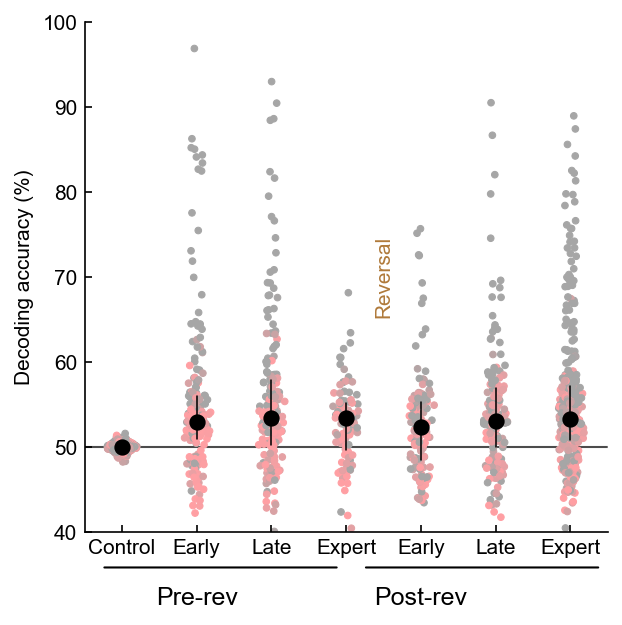

In [25]:
#Firing rate modulation graphs

size=10

#FRmod_baseline_median = np.nanmedian(np.abs(FRmod_preearly))
#print('baseline = '+str(FRmod_baseline_median))

fig, ax = plt.subplots(figsize=(4.5,4.5))
# fig, ax = plt.subplots(figsize=(5,3))
data = [passive_Control_Stim_Dec_overall,passive_Stim_Dec_preearly,passive_Stim_Dec_prelate,passive_Stim_Dec_preexpert,passive_Stim_Dec_postearly,passive_Stim_Dec_postlate,passive_Stim_Dec_postexpert]
FRmoddata = [passive_FRmod_Stim_overall,passive_FRmod_preearly,passive_FRmod_prelate,passive_FRmod_preexpert,passive_FRmod_postearly,passive_FRmod_postlate,passive_FRmod_postexpert]
#data = [np.abs(column[np.isfinite(column)]) for column in data]
#num_animal = [preearly_animal_num,prelate_animal_num,preexpert_animal_num,postearly_animal_num,postlate_animal_num,postexpert_animal_num]
labels = ['Control','Early','Late','Expert','Early','Late','Expert']
numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.4,minjitter=0.075)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.4,minjitter=0.075)
colors = NCR_CR_cmap((np.concatenate(FRmoddata)-1)/5)

ax.scatter(X, Y, s=size, ec=colors, fc=colors, lw=0.5,zorder=-10)
#ax.set_yscale('log',subs=[])

#Plot summary
for idx,column in enumerate(data):
    column = ilep.rmnan(column)
    eye_color=GOOD_GREY#NCR_CR_cmap((percentCR-40)/20)
    
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    #border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    border_color=colorsys.hls_to_rgb(h,l,s)
    
    border_color = 'k'
    eye_color = 'k'

    summary_size=50
    summary_width=0.75
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    
    ax.scatter([idx], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx, idx], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

ax.axhline(0.5,color='k',linestyle='-',zorder=-20,lw=1)

ax.set_ylim([0.4,1])
ax.set_yticks([0.4,0.5,0.6,0.7,0.8,0.9,1])
ax.set_yticklabels(['40','50','60','70','80','90','100'])
ax.set_ylabel('Decoding accuracy (%)')

ax.set_xlim([-0.5,6.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())

    
rev = 3.5
size = 0.3
center = np.mean(ax.get_ylim())
ax.text(rev,center,'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center',rotation=90)
#ax.plot([rev,rev],[ax.get_ylim()[0],center-size],color=SWITCH_COLOR,lw=1,linestyle='-')
#ax.plot([rev,rev],[center+size,ax.get_ylim()[1]],color=SWITCH_COLOR,lw=1,linestyle='-')

ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.3,zorder=-5)

#NORMAL
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim())+0.01
t1 = ax.text(xtick_pos_pre, Yval, 'Pre-rev', ha='center', va='top', fontsize=12,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post-rev', ha='center', va='top',  fontsize=12,color='k')
ax.annotate('', xy=(0.03, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(0.99, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Passive decoding performance over phases V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=(t1,t2), bbox_inches='tight')

In [17]:
data_dec = SimpleNamespace()
data_dec.preearly = passive_Stim_Dec_preearly
data_dec.prelate = passive_Stim_Dec_prelate
data_dec.preexpert = passive_Stim_Dec_preexpert
data_dec.postearly = passive_Stim_Dec_postearly
data_dec.postlate = passive_Stim_Dec_postlate
data_dec.postexpert = passive_Stim_Dec_postexpert
ilep.nonparametricIndependentStatsCompareToPreearly(data_dec)
pass

            Source         SS      DF        MS         F     p-unc       np2
0            phase   0.053587     4.0  0.013397  1.944400  0.100526  0.003929
1          context   0.013955     1.0  0.013955  2.025404  0.154846  0.001026
2  phase * context   0.061537     4.0  0.015384  2.232852  0.063240  0.004509
3         Residual  13.586994  1972.0  0.006890       NaN       NaN       NaN

          phase         A             B     p-unc    p-corr    hedges
11   post-early  baseline  experimental  0.049087  0.245437  0.267481
12  post-expert  baseline  experimental  0.274228  0.563383 -0.054381
13    post-late  baseline  experimental  0.965869  0.965869  0.065239
14   pre-expert  baseline  experimental  0.439108  0.563383  0.275364
15     pre-late  baseline  experimental  0.450706  0.563383 -0.058290


In [18]:
data_passive = SimpleNamespace()
data_passive.preearly = passive_Stim_Dec_preearly
data_passive.prelate = passive_Stim_Dec_prelate
data_passive.preexpert = passive_Stim_Dec_preexpert
data_passive.postearly = passive_Stim_Dec_postearly
data_passive.postlate = passive_Stim_Dec_postlate
data_passive.postexpert = passive_Stim_Dec_postexpert

data_active = SimpleNamespace()
data_active.preearly = Stim_Dec_preearly
data_active.prelate = Stim_Dec_prelate
data_active.preexpert = Stim_Dec_preexpert
data_active.postearly = Stim_Dec_postearly
data_active.postlate = Stim_Dec_postlate
data_active.postexpert = Stim_Dec_postexpert

ilep.nonparametricIndependentStatsCompareToOther(data_passive,data_active)
pass

            Source         SS      DF        MS          F         p-unc  \
0            phase   0.179843     5.0  0.035969   5.973885  1.696747e-05   
1          context   0.323609     1.0  0.323609  53.747027  3.176479e-13   
2  phase * context   0.283774     5.0  0.056755   9.426194  6.633453e-09   
3         Residual  13.390631  2224.0  0.006021        NaN           NaN   

        np2  
0  0.013253  
1  0.023597  
2  0.020752  
3       NaN  

          phase  A  B         p-unc        p-corr    hedges
16   post-early  A  B  5.642704e-07  1.128541e-06 -0.468640
17  post-expert  A  B  7.235622e-10  2.170687e-09 -0.491129
18    post-late  A  B  1.118189e-04  1.677283e-04 -0.269474
19    pre-early  A  B  2.811890e-01  2.811890e-01 -0.021753
20   pre-expert  A  B  1.266271e-11  7.597624e-11 -1.085930
21     pre-late  A  B  1.222753e-01  1.467304e-01  0.063200


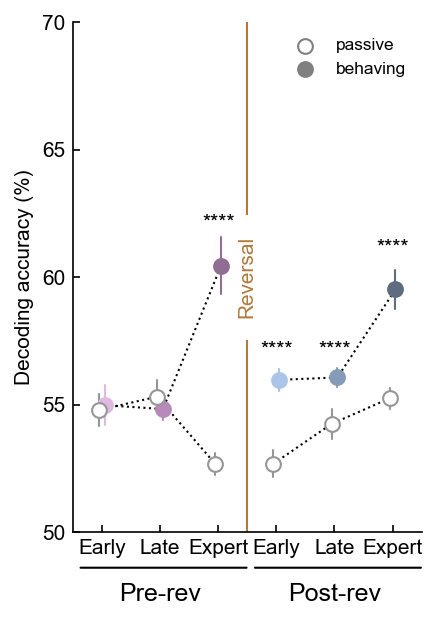

In [53]:
#Firing rate modulation graphs
size=5
numCon = 6

labels = ['Early','Late','Expert','Early','Late','Expert']
offset_distance = 0.05

fig, ax = plt.subplots(figsize=(3,4.5)) #5/3 with height of 4.5

data = [Stim_Dec_preearly,Stim_Dec_prelate,Stim_Dec_preexpert,Stim_Dec_postearly,Stim_Dec_postlate,Stim_Dec_postexpert]
data = [ilep.rmnan(d) for d in data]
#Plot summary
colmaxes = [np.nan]*6
for idx,column in enumerate(data):
    eye_color = PHASE_COLORS[idx]
    border_color=eye_color
    summary_size=50
    summary_width=1
    
    #Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    median = np.mean(column)
    Q1 = median - sem(column)
    Q3 = median + sem(column)
    colmaxes[idx] = Q3
    
    ax.scatter([idx+offset_distance], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+offset_distance, idx+offset_distance], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
medians = [np.mean(col) for col in data]
plt.plot(np.linspace(0,2,3)+offset_distance,medians[0:3],color='k',linestyle=':',lw=1)
plt.plot(np.linspace(3,5,3)+offset_distance,medians[3:6],color='k',linestyle=':',lw=1)
    
######################################################################################################################################################
passive_data = [passive_Stim_Dec_preearly,passive_Stim_Dec_prelate,passive_Stim_Dec_preexpert,passive_Stim_Dec_postearly,passive_Stim_Dec_postlate,passive_Stim_Dec_postexpert]
passive_data = [ilep.rmnan(d) for d in passive_data]

#Plot summary
passive_colmaxes = [np.nan]*6
for idx,column in enumerate(passive_data):
    border_color=GOOD_GREY
    eye_color='white'

    summary_size=50
    summary_width=1
    
    #Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    median = np.mean(column)
    Q1 = median - sem(column)
    Q3 = median + sem(column)
    passive_colmaxes[idx] = Q3
    
    ax.scatter([idx-offset_distance], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10,marker='o')
    ax.plot([idx-offset_distance, idx-offset_distance], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
medians = [np.mean(col) for col in passive_data]
plt.plot(np.linspace(0,2,3)-offset_distance,medians[0:3],color='k',linestyle=':',lw=1)
plt.plot(np.linspace(3,5,3)-offset_distance,medians[3:6],color='k',linestyle=':',lw=1)


ax.set_ylim([0.5,0.7])
ax.set_yticks([0.5,0.55,0.6,0.65,0.7])
ax.set_yticklabels([50,55,60,65,70])
ax.set_ylabel('Decoding accuracy (%)')

ax.set_xlim(ax.get_xlim())
ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)


# ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=-10,lw=1)
# ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')

ax.scatter([],[],ec='grey',fc='white',s=summary_size,lw=summary_width,zorder=10,marker='o',label='passive')
ax.scatter([],[],ec='grey',fc='grey',s=summary_size,lw=summary_width,zorder=10,marker='o',label='behaving')
lgd = ax.legend(frameon=False)#,loc=(0.6,0.1))




size = 0.025
rev = 2.5
center = np.mean(ax.get_ylim())
ax.text(rev,center,'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center',rotation=90)
ax.plot([rev,rev],[ax.get_ylim()[0],center-size],color=SWITCH_COLOR,lw=1,linestyle='-')
ax.plot([rev,rev],[center+size,ax.get_ylim()[1]],color=SWITCH_COLOR,lw=1,linestyle='-')


    

#statistics
ax.text(2,0.625,str('****'),verticalalignment='top',horizontalalignment='center')
ax.text(3,0.575,str('****'),verticalalignment='top',horizontalalignment='center')
ax.text(4,0.575,str('****'),verticalalignment='top',horizontalalignment='center')
ax.text(5,0.615,str('****'),verticalalignment='top',horizontalalignment='center')
#ax.text(-0.4,9.5,'CR',color=CR_COLOR,horizontalalignment='left',verticalalignment='top')
#ax.text(-0.4,0.5,'NCR',color=NCR_COLOR,horizontalalignment='left',verticalalignment='bottom')
# statsbar(ax,10,[1-offset_distance,1+offset_distance],stemheights=[passive_colmaxes[1] , colmaxes[1]],text='*',lw=0.5)
# statsbar(ax,10,[4-offset_distance,4+offset_distance],stemheights=[passive_colmaxes[4] , colmaxes[4]],text='****',lw=0.5)
# statsbar(ax,10,[5-offset_distance,5+offset_distance],stemheights=[passive_colmaxes[5] , colmaxes[5]],text='****',lw=0.5)


xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim())+0.005
t1 = ax.text(xtick_pos_pre, Yval, 'Pre-rev', ha='center', va='top', fontsize=12,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post-rev', ha='center', va='top',  fontsize=12,color='k')
ax.annotate('', xy=(0.01, -0.07), xycoords='axes fraction', xytext=(0.51, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.51, -0.07), xycoords='axes fraction', xytext=(1.01, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC Mean of Decoding over learning V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=(lgd,t1,t2), bbox_inches='tight')

# Decoding Perf. Task Encoders

In [14]:
TE_Stim_Dec_preearly = []
TE_Stim_Dec_prelate = []
TE_Stim_Dec_preexpert = []
TE_Stim_Dec_postearly = []
TE_Stim_Dec_postlate = []
TE_Stim_Dec_postexpert = []

passive_TE_Stim_Dec_preearly = []
passive_TE_Stim_Dec_prelate = []
passive_TE_Stim_Dec_preexpert = []
passive_TE_Stim_Dec_postearly = []
passive_TE_Stim_Dec_postlate = []
passive_TE_Stim_Dec_postexpert = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumACSession,EnumACClust))):
    ACsessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        FRmod = ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation
    except Exception as e:
        print(e)
        FRmod = np.nan
    
    stim_acc = getDataPoint(dec_df,session,clust,'stimulus','weighted_accuracy')
    choice_acc = getDataPoint(dec_df,session,clust,'response','weighted_accuracy')
    stim_acc_control = getDataPoint(dec_df,session,clust,'stimulus','synthetic_control_weighted_accuracy')
    choice_acc_control = getDataPoint(dec_df,session,clust,'response','synthetic_control_weighted_accuracy')
    
    if stim_acc < task_encoder_threshold_p:
        continue
    
    if getDataPoint(dec_df,session,clust,'stimulus','pval_synthetic_control') > 0.05:
        stim_acc = np.nan
    if getDataPoint(dec_df,session,clust,'response','pval_synthetic_control') > 0.05:
        choice_acc = np.nan
        
    if EILphases[idx] not in ['pre expert','post expert'] and ACsessionfile.meta.animal in ['DS_15','DS_19']:
        continue

    #1,2,3,4
    if ACsessionfile.meta.day_of_training <= pre_early:
        passive_Stim_Dec_preearly.append(stim_acc)
        passive_Choice_Dec_preearly.append(choice_acc)
        passive_Control_Stim_Dec_preearly.append(stim_acc_control)
        passive_Control_Choice_Dec_preearly.append(choice_acc_control)
        
    #5,6
    if ACsessionfile.meta.day_of_training <= pre_late and ACsessionfile.meta.day_of_training >pre_early:
        passive_Stim_Dec_prelate.append(stim_acc)
        passive_Choice_Dec_prelate.append(choice_acc)
        passive_Control_Stim_Dec_prelate.append(stim_acc_control)
        passive_Control_Choice_Dec_prelate.append(choice_acc_control)
    
    #7,8
    if ACsessionfile.meta.day_of_training <= pre_expert and ACsessionfile.meta.day_of_training >pre_late:
        passive_Stim_Dec_preexpert.append(stim_acc)
        passive_Choice_Dec_preexpert.append(choice_acc)
        passive_Control_Stim_Dec_preexpert.append(stim_acc_control)
        passive_Control_Choice_Dec_preexpert.append(choice_acc_control)
        
    #9,10,11,12
    if ACsessionfile.meta.day_of_training <= post_early and ACsessionfile.meta.day_of_training >pre_expert:
        passive_Stim_Dec_postearly.append(stim_acc)
        passive_Choice_Dec_postearly.append(choice_acc)
        passive_Control_Stim_Dec_postearly.append(stim_acc_control)
        passive_Control_Choice_Dec_postearly.append(choice_acc_control)

    #13,14,15
    if ACsessionfile.meta.day_of_training <= post_late and ACsessionfile.meta.day_of_training >post_early:
        passive_Stim_Dec_postlate.append(stim_acc)
        passive_Choice_Dec_postlate.append(choice_acc)
        passive_Control_Stim_Dec_postlate.append(stim_acc_control)
        passive_Control_Choice_Dec_postlate.append(choice_acc_control)
    
    #16,17,18,19,20,21
    if ACsessionfile.meta.day_of_training >= post_expert:
        passive_Stim_Dec_postexpert.append(stim_acc)
        passive_Choice_Dec_postexpert.append(choice_acc)
        passive_Control_Stim_Dec_postexpert.append(stim_acc_control)
        passive_Control_Choice_Dec_postexpert.append(choice_acc_control)
        
passive_Stim_Dec_preearly = np.array(passive_Stim_Dec_preearly)
passive_Stim_Dec_prelate = np.array(passive_Stim_Dec_prelate)
passive_Stim_Dec_preexpert = np.array(passive_Stim_Dec_preexpert)
passive_Stim_Dec_postearly = np.array(passive_Stim_Dec_postearly)
passive_Stim_Dec_postlate = np.array(passive_Stim_Dec_postlate)
passive_Stim_Dec_postexpert = np.array(passive_Stim_Dec_postexpert)

passive_Choice_Dec_preearly = np.array(passive_Choice_Dec_preearly)
passive_Choice_Dec_prelate = np.array(passive_Choice_Dec_prelate)
passive_Choice_Dec_preexpert = np.array(passive_Choice_Dec_preexpert)
passive_Choice_Dec_postearly = np.array(passive_Choice_Dec_postearly)
passive_Choice_Dec_postlate = np.array(passive_Choice_Dec_postlate)
passive_Choice_Dec_postexpert = np.array(passive_Choice_Dec_postexpert)

passive_Control_Stim_Dec_preearly = np.array(passive_Control_Stim_Dec_preearly)
passive_Control_Stim_Dec_prelate = np.array(passive_Control_Stim_Dec_prelate)
passive_Control_Stim_Dec_preexpert = np.array(passive_Control_Stim_Dec_preexpert)
passive_Control_Stim_Dec_postearly = np.array(passive_Control_Stim_Dec_postearly)
passive_Control_Stim_Dec_postlate = np.array(passive_Control_Stim_Dec_postlate)
passive_Control_Stim_Dec_postexpert = np.array(passive_Control_Stim_Dec_postexpert)

passive_Control_Choice_Dec_preearly = np.array(passive_Control_Choice_Dec_preearly)
passive_Control_Choice_Dec_prelate = np.array(passive_Control_Choice_Dec_prelate)
passive_Control_Choice_Dec_preexpert = np.array(passive_Control_Choice_Dec_preexpert)
passive_Control_Choice_Dec_postearly = np.array(passive_Control_Choice_Dec_postearly)
passive_Control_Choice_Dec_postlate = np.array(passive_Control_Choice_Dec_postlate)
passive_Control_Choice_Dec_postexpert = np.array(passive_Control_Choice_Dec_postexpert)

1442it [00:16, 84.96it/s] 
